In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import minimize, curve_fit
from scipy.stats import mode
from scipy.signal import argrelextrema
from numpy.random import normal

from statsmodels.robust import mad

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

In [18]:
def create_datafilename(sol, dr='/Users/brian/Downloads/ps_bundle/data_calibrated'):
    filenames = glob.glob(dr + "/*/*_calib_*.csv")
    
    # file names have some zeros and then the sol number; Add the right number of zeros
    file_stem = ""
    for i in range(4 - len(str(sol))):
        file_stem += "0"
    file_stem += str(sol)
    
    res = [i for i in filenames if str(file_stem) + "_01" in i] 
    return res

def convert_ltst(sol_data):
    LTST = np.zeros(sol_data['LTST'].size)
    LTST_and_sol = np.zeros(sol_data['LTST'].size)
    
    for i in range(len(sol_data['LTST'])):
        sol, time = sol_data['LTST'][i].decode("utf-8").split()
        hr, mn, sc = time.split(":")
        
        cur_LTST = float(hr) + float(mn)/60. + float(sc)/3600.
        LTST[i] = cur_LTST
        LTST_and_sol[i] = float(sol)*24. + cur_LTST
        
    return LTST, LTST_and_sol

def retrieve_vortices(sol, sol_filename, Spigas_data, window_width=30./3600, subtract_time=True):
    sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)
    LTST, LTST_and_sol = convert_ltst(sol_data)

    vortices = []
    central_times = []
    
    ind = Spigas_data['SOL'] == sol
    for time in Spigas_data['_LTST_'][ind]:
        x = LTST
        time_ind = np.abs(x - time) < window_width
        if(subtract_time):
            x = LTST - time
            time_ind = np.abs(x) < window_width
            
        vortices.append([x[time_ind], sol_data['PRESSURE'][time_ind]])
        central_times.append(time)
                                           
    return vortices

def central_times(sol, sol_filename, Spigas_data):
    ind = Spigas_data['SOL'] == sol
    return Spigas_data['_LTST_'][ind]

def modified_lorentzian(t, baseline, slope, t0, DeltaP, Gamma):
    # Equation 7 from Kahapaa+ (2016)
    return baseline + slope*(t - t0) - DeltaP/(((t - t0)/(Gamma/2.))**2 + 1)

# From https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, w, mode='valid'):
    return np.convolve(x, np.ones(w), mode) / w

def moving_std(x, w, mode='valid'):
#     sqrt(<x^2> - <x>^2)
    avg_sq = moving_average(x*x, w, mode=mode)
    sq_avg = moving_average(x, w, mode=mode)**2.
    
    return np.sqrt(avg_sq - sq_avg)

def redchisqg(ydata,ymod,deg=2,sd=None):
    """  
    Returns the reduced chi-square error statistic for an arbitrary model, 
    chisq/nu, where nu is the number of degrees of freedom. If individual   
    standard deviations (array sd) are supplied, then the chi-square error
    statistic is computed as the sum of squared errors divided by the standard   
    deviations. See http://en.wikipedia.org/wiki/Goodness_of_fit for reference.
    
    ydata,ymod,sd assumed to be Numpy arrays. deg integer.
    
    Usage:
    chisq=redchisqg(ydata,ymod,n,sd)
    
    where  
    ydata : data  
    ymod : model evaluated at the same x points as ydata
    n : number of free parameters in the model  
    sd : uncertainties in ydata
    
    Rodrigo Nemmen
    http://goo.gl/8S1Oo
    """
    # Chi-square statistic
    if(sd==None):
        chisq=np.sum((ydata-ymod)**2)
    else:
        chisq=np.sum( ((ydata-ymod)/sd)**2 )
        
    # Number of degrees of freedom assuming 2 free parameters
    nu=ydata.size - 1. - deg
    
    return chisq/nu       

def condition_vortex(vortex):
    
    _, unq = np.unique(vortex[0], return_index=True)            
    x = vortex[0][unq]
    y = vortex[1][unq]
    
    # Remove NaNs
    ind = np.isfinite(x) & np.isfinite(y)
    x = x[ind]
    y = y[ind]
    
    return x, y

def fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None):
    
    x, y = condition_vortex(vortex)
    
    if(zoomed_in is not None):
        ind = np.abs(x - init_params[2]) < zoomed_in
        x = x[ind]
        y = y[ind]
    
    # First fit out the long-term slope
    fit_params = np.polyfit(x, y, 1)
    detrended_data = y - np.polyval(fit_params, x)
                    
    popt, pcov = curve_fit(modified_lorentzian, x, y, p0=init_params, bounds=bounds)
    ymod = modified_lorentzian(x, *popt)
    
    if(rescale_uncertainties):       
        sd = mad(y - ymod)
        red_chisq = redchisqg(y, ymod, deg=5, sd=sd)
        
        pcov *= np.sqrt(red_chisq)
        
    return popt, np.sqrt(np.diag(pcov))

def determine_init_params(vortex, 
                          init_baseline=None, init_slope=None, init_t0=None, init_DeltaP=None, init_Gamma=None):

    x, y = condition_vortex(vortex) 
    fit_params = np.polyfit(x, y, 1)
    detrended_y = y - np.polyval(fit_params, x)
    
    if(init_baseline is None):
        init_baseline = np.median(y)
        
    if(init_slope is None):
        init_slope = fit_params[0]
        
    if(init_t0 is None):
        init_t0 = x[np.argmin(detrended_y)]

    if(init_DeltaP is None):
        init_DeltaP = 10.
        
    if(init_Gamma is None):
        init_Gamma = 2./3600.
        
    return np.array([init_baseline, init_slope, init_t0, init_DeltaP, init_Gamma])

def determine_bounds(vortex, init_params, init_t0_fac=0.0002, init_DeltaP_fac=1000.):
    
    x, y = condition_vortex(vortex)
    
    return ([np.min(y), -10.*np.abs(init_params[1]), (1-init_t0_fac)*init_params[2], 0., 0.5/3600], 
            [np.max(y),  10.*np.abs(init_params[1]), (1+init_t0_fac)*init_params[2], init_DeltaP_fac*init_params[3],
               300./3600])

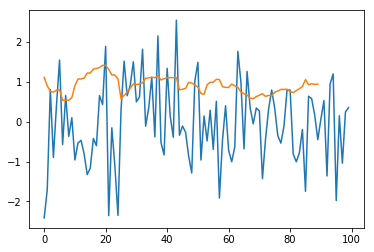

In [3]:
window = 11

x = np.arange(0, 100, 1)
test_data = np.linspace(-1, 1, 100)
# plt.plot(x)

convolved_x = moving_average(x, window)
convolved_data = moving_average(test_data, window)
# plt.plot(convolved_x)

# We want the average of all the points BEFORE the current point and NOT including the current point!
the_array_I_want = np.zeros_like(x)
the_array_I_want[window:] = convolved_x[0:-1]

rand = normal(size=len(x))
st = moving_std(rand, window)
plt.plot(rand)
plt.plot(st)

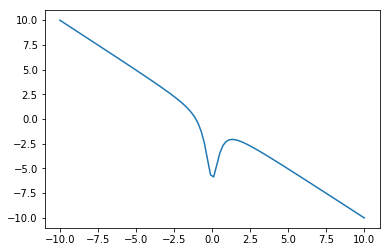

In [4]:
t = np.linspace(-10., 10., 100)
baseline = 0.
slope = -1.
t0 = 0.
DeltaP = 6.
Gamma = 1.

plt.plot(t, modified_lorentzian(t, baseline, slope, t0, DeltaP, Gamma))

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  import sys
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


-9.183
-4.053


Text(0.025, 0.9, '(d)')

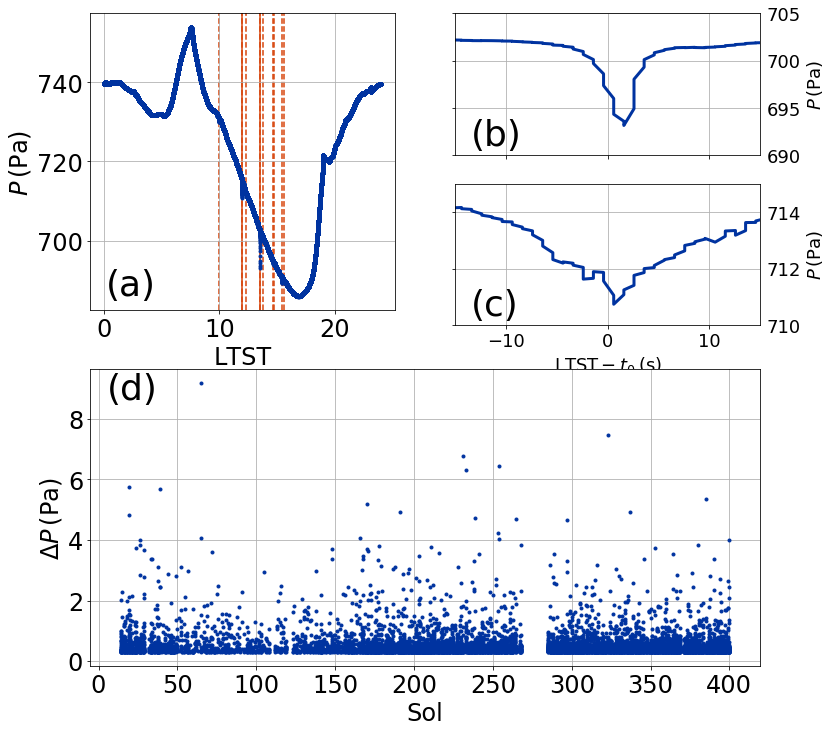

In [8]:
# 2020 Jul 2 - Illustrative figure

fig = plt.figure(figsize=(12, 12))

sol = 65
filename = "alldrop_ordered.txt"
Spigas_data = np.genfromtxt(filename, names=True, delimiter=";", dtype=None)
ind = Spigas_data['SOL'] == sol

#####################
# Time-Series Panel #
#####################
ax_timeseries = fig.add_subplot(221)
sol_filename = create_datafilename(sol)
# AOBT SCLK LMST LTST UTC PRESSURE PRESSURE_FREQUENCY PRESSURE_TEMP PRESSURE_TEMP_FREQUENCY
sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)
LTST, LTST_and_sol = convert_ltst(sol_data)
ax_timeseries.plot(LTST, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)

# Add detected vortices
for i in range(len(Spigas_data['_LTST_'][ind])):
    if((i == 0) or (i == 1)):
            print(Spigas_data['_DROP_'][ind][i])
            ax_timeseries.axvline(Spigas_data['_LTST_'][ind][i], color=BoiseState_orange, zorder=-1)
    ax_timeseries.axvline(Spigas_data['_LTST_'][ind][i], color=BoiseState_orange, zorder=-1, ls='--')

ax_timeseries.tick_params(labelsize=24)
ax_timeseries.set_xlabel("LTST", fontsize=24)
ax_timeseries.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=24)
ax_timeseries.grid(True)
ax_timeseries.annotate("(a)", (0.05, 0.05), fontsize=36, xycoords="axes fraction")
# ax_timeseries.set_xlim([8, 18])

######################
# Zoomed in profiles #
######################
ax_deepest = fig.add_subplot(422)
ax_deepest.plot((LTST - Spigas_data['_LTST_'][ind][0])*3600., sol_data['PRESSURE'], 
                color=BoiseState_blue, lw=3)
ax_deepest.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=18)
ax_deepest.yaxis.set_label_position("right")
ax_deepest.set_xlim([-15, 15])
ax_deepest.set_ylim([690, 705])
ax_deepest.tick_params(labelbottom=False, labelleft=False, labelright=True, labelsize=18)
ax_deepest.grid(True)
ax_deepest.annotate("(b)", (0.05, 0.07), fontsize=36, xycoords="axes fraction")

ax_2nd_deepest = fig.add_subplot(424, sharex=ax_deepest)
ax_2nd_deepest.plot((LTST - Spigas_data['_LTST_'][ind][1])*3600., sol_data['PRESSURE'], 
                    color=BoiseState_blue, lw=3)
ax_2nd_deepest.set_xlabel(r'${\rm LTST} - t_0\,\left({\rm s} \right)$', fontsize=18)
ax_2nd_deepest.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=18)
ax_2nd_deepest.yaxis.set_label_position("right")
ax_2nd_deepest.set_xlim([-15, 15])
ax_2nd_deepest.set_ylim([710, 715])
ax_2nd_deepest.tick_params(labelleft=False, labelright=True, labelsize=18)
ax_2nd_deepest.grid(True)
ax_2nd_deepest.annotate("(c)", (0.05, 0.07), fontsize=36, xycoords="axes fraction")

# ax_2nd_deepest.set_ylim([692, 703])

##############
# Detections #
##############

ax_detections = fig.add_subplot(212)
ax_detections.plot(Spigas_data['SOL'], -Spigas_data['_DROP_'], marker='.', ls='', color=BoiseState_blue)
ax_detections.tick_params(labelsize=24)
ax_detections.set_xlabel("Sol", fontsize=24)
ax_detections.set_ylabel(r'$\Delta P\,\left({\rm Pa}\right)$', fontsize=24)
ax_detections.grid(True)
ax_detections.annotate("(d)", (0.025, 0.9), fontsize=36, xycoords="axes fraction")

# fig.savefig("../../figures/vortex_illustration.png", dpi=500, bbox_inches='tight')

In [23]:
# 2020 Jun 30 - Fit all the vortices
filename = "alldrop_ordered.txt"
Spigas_data = np.genfromtxt(filename, names=True, delimiter=";", dtype=None)

# Save the durations and residuals to a new file
new_filename = "alldrop_ordered_durations.txt"
f = open(new_filename, "w")
f.write("# sol, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, datafile\n")

unq_srt_sols = np.unique(np.sort(Spigas_data['SOL']))

# ind = unq_srt_sols == 244

for cur_sol in unq_srt_sols[1:]:
    sol_filename = create_datafilename(cur_sol)

    # I don't have all the data yet, and also the vortices in sol 14 are off for some reason
    if(len(sol_filename) >= 1):
        vortices = retrieve_vortices(cur_sol, sol_filename, Spigas_data, 
                                     window_width=300./3600., subtract_time=False)
        times = central_times(cur_sol, sol_filename, Spigas_data)
        
        for i in range(len(vortices)):
#         for i in [18]:
            
            init_params = determine_init_params(vortices[i], init_t0=times[i])
            bounds = determine_bounds(vortices[i], init_params)
            
            popt, uncertainties = fit_vortex(vortices[i], init_params, bounds)
            # The first bounds check - we zoom in a bit on the feature to see if we can't improve the fit.
            if(np.any(np.isclose(popt[2:5], bounds[0][2:5], rtol=1e-4) |\
               np.isclose(popt[2:5], bounds[1][2:5], rtol=1e-4))):

                print("first bounds check")

#                 x = vortices[i][0][np.abs(vortices[i][0] - popt[2]) < 10.*popt[4]]
#                 y = vortices[i][1][np.abs(vortices[i][0] - popt[2]) < 10.*popt[4]]

#                 _, unq = np.unique(x, return_index=True)            
#                 if(len(x[unq]) > 3):
#                     y = y[unq]
#                     x = x[unq]

                init_params = determine_init_params(vortices[i], init_t0=times[i])
                bounds = determine_bounds(vortices[i], init_params)
                bounds[0][2] = init_params[2] - 10./3600
                bounds[1][2] = init_params[2] + 10./3600
                
                popt, uncertainties = fit_vortex(vortices[i], init_params, bounds)

# #                     plt.plot((x - popt[2])*3600., y - np.polyval([popt[1], popt[0]], x), color=BoiseState_blue, lw=3)
# #                     plt.plot((x - popt[2])*3600., modified_lorentzian(x, *popt) - np.polyval([popt[1], popt[0]], x), 
# #                         color=BoiseState_orange, lw=3, ls='--')
# #                     plt.axvline((times[i] - popt[2])*3600., ls='--', zorder=-1)

#                     popt, pcov = curve_fit(modified_lorentzian, x, y, 
#                               p0=[init_baseline, init_slope, init_t0, init_DeltaP, init_Gamma], bounds=bounds)

                # Second bounds check -
                # If the best-fit FWHM hits the max/min value, then re-fit with different bounds.
                # It seems that when FWHM his max, it's because the routine is fitting too wide a feature.
                if(np.any(np.isclose(popt[2:5], bounds[0][2:5], rtol=1e-4) |\
                   np.isclose(popt[2:5], bounds[1][2:5], rtol=1e-4))):

                    print("second bounds check")                    
                    popt, uncertainties = fit_vortex(vortices[i], init_params, bounds, zoomed_in=15./3600)

#             plt.plot((x - popt[2])*3600., y - np.polyval([popt[1], popt[0]], x), 
#                      color=BoiseState_blue, lw=3)
#             plt.plot((x - popt[2])*3600., modified_lorentzian(x, *popt) - np.polyval([popt[1], popt[0]], x), 
#                      color=BoiseState_orange, lw=3, ls='--')

#             plt.axvline((times[i] - popt[2])*3600., ls='--', zorder=-1)
#             plt.axvline((init_t0 - popt[2])*3600.)
#             plt.axvline(popt[2], zorder=-1, color=BoiseState_orange)
            
            write_filename = sol_filename[0].split("/")[-1]
            write_str = "%i, %g, %g, %g, %g, %g, %g, %s" %\
                (cur_sol, popt[2], uncertainties[2], popt[3], uncertainties[3], 
                 popt[4]*3600., uncertainties[4]*3600, write_filename)
            print(i, ", ", write_str)
            f.write(write_str + "\n")

#             except:
#                 print("Fit failed - sol, vortex: ", cur_sol, i)
#                 plt.plot(x, detrended_data, color=BoiseState_blue, marker='.', ls='')
#                 plt.axvline(times[i], zorder=-1, color=BoiseState_orange)
#                 break
                   
f.close()

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


0 ,  15, 13.1656, 3.48982e-05, 2.51757, 0.0745095, 8.48978, 0.363425, ps_calib_0015_01.csv
1 ,  15, 12.4142, 4.90849e-05, 1.22939, 0.0419026, 10.3684, 0.513743, ps_calib_0015_01.csv
2 ,  15, 13.1838, 0.000843865, 0.560207, 0.205528, 16.5585, 8.9811, ps_calib_0015_01.csv
first bounds check
second bounds check
3 ,  15, 14.1219, 2.32699e-05, 0.873906, 0.134627, 1.29746, 0.269583, ps_calib_0015_01.csv
4 ,  15, 12.907, 0.00036021, 0.445328, 0.0101318, 112.668, 4.97175, ps_calib_0015_01.csv
5 ,  15, 15.1452, 8.0992e-05, 0.587494, 0.0259976, 13.1769, 0.85413, ps_calib_0015_01.csv
6 ,  15, 12.5451, 4.64607e-05, 0.600523, 0.151218, 1.81484, 0.643468, ps_calib_0015_01.csv
first bounds check
second bounds check
7 ,  15, 14.1829, 2.24216e-05, 0.383078, 0.123899, 1.22892, 0.479975, ps_calib_0015_01.csv
8 ,  15, 14.8795, 0.000103998, 0.419619, 0.0410651, 7.65125, 1.08059, ps_calib_0015_01.csv
first bounds check
second bounds check
9 ,  15, 14.0433, 7.48063e-05, 0.114964, 0.0114623, 5.34681, 1.02316,

second bounds check
11 ,  19, 13.1225, 0.000107939, 0.078699, 0.0227704, 2.52264, 1.17686, ps_calib_0019_01.csv
first bounds check
second bounds check
12 ,  19, 10.5183, 8.07527e-05, 0.320429, 0.0328686, 5.61044, 1.11898, ps_calib_0019_01.csv
first bounds check
second bounds check
13 ,  19, 10.2876, 3.03173e-05, 0.393986, 0.163169, 1.30224, 0.683804, ps_calib_0019_01.csv
14 ,  19, 11.2369, 0.000210829, 0.425778, 0.0213311, 30.2755, 2.32959, ps_calib_0019_01.csv
first bounds check
second bounds check
15 ,  19, 11.8862, 0.000215728, 0.116424, 0.251516, 0.923667, 2.07411, ps_calib_0019_01.csv
16 ,  19, 12.4865, 0.000279365, 0.341529, 0.0359196, 19.1208, 2.99403, ps_calib_0019_01.csv
17 ,  19, 9.60049, 0.000124097, 0.454361, 0.038619, 10.5118, 1.29935, ps_calib_0019_01.csv
first bounds check
second bounds check
18 ,  19, 12.6728, 0.000185033, 0.215101, 0.0299193, 11.4562, 3.3567, ps_calib_0019_01.csv
first bounds check
second bounds check
19 ,  19, 12.3769, 9.08348e-05, 0.263382, 0.02641, 

23 ,  21, 14.7621, 0.000758443, 0.506056, 0.467249, 22.2877, 14.0671, ps_calib_0021_01.csv
first bounds check
second bounds check
24 ,  21, 13.1801, 0.000184598, 0.0827179, 0.0200289, 5.4253, 2.49785, ps_calib_0021_01.csv
25 ,  21, 9.33251, 7.62036e-05, 0.371188, 0.0642634, 1.17442, 0.342574, ps_calib_0021_01.csv
first bounds check
second bounds check
26 ,  21, 14.7787, 0.000139215, 0.203925, 0.0562929, 3.60451, 1.73083, ps_calib_0021_01.csv
27 ,  21, 14.7063, 0.000296748, 0.276622, 0.0303872, 19.4454, 3.18313, ps_calib_0021_01.csv
28 ,  21, 15.8584, 0.000343092, 0.189235, 0.0197092, 23.7085, 3.72338, ps_calib_0021_01.csv
29 ,  21, 13.5976, 0.000186478, 0.34965, 0.0456737, 10.278, 1.95128, ps_calib_0021_01.csv
30 ,  21, 9.26265, 0.000185532, 0.237402, 0.0153459, 20.6598, 1.99676, ps_calib_0021_01.csv
first bounds check
second bounds check
31 ,  21, 11.1344, 0.000259862, 0.122443, 0.0301908, 20.3974, 6.43399, ps_calib_0021_01.csv
first bounds check
second bounds check
0 ,  22, 14.2963, 

first bounds check
second bounds check
32 ,  24, 14.819, 0.000348646, 0.142132, 0.0381102, 10.46, 6.05576, ps_calib_0024_01.csv
33 ,  24, 15.3552, 0.00117397, 0.240238, 0.0105115, 252.919, 22.3464, ps_calib_0024_01.csv
0 ,  25, 13.7599, 0.000566985, 0.364674, 0.0129303, 113.798, 7.8482, ps_calib_0025_01.csv
1 ,  25, 10.0715, 4.19794e-05, 0.52373, 0.0421123, 3.78425, 0.435393, ps_calib_0025_01.csv
2 ,  25, 11.6173, 0.000201744, 0.544505, 0.0110081, 71.3744, 2.4957, ps_calib_0025_01.csv
3 ,  25, 11.3937, 7.41884e-05, 0.580448, 0.0764729, 4.07001, 0.767324, ps_calib_0025_01.csv
4 ,  25, 15.4737, 0.000243012, 0.354385, 0.0156362, 39.5918, 2.75504, ps_calib_0025_01.csv
5 ,  25, 15.2779, 1.84553e-05, 0.583263, 0.0865067, 1.59477, 0.317383, ps_calib_0025_01.csv
first bounds check
second bounds check
6 ,  25, 14.6933, 0.000345561, 0.261862, 0.0947652, 19.3805, 7.32414, ps_calib_0025_01.csv
first bounds check
second bounds check
7 ,  25, 13.6017, 6.09231e-05, 0.315565, 0.0262857, 5.21192, 0.827

second bounds check
14 ,  28, 14.7699, 9.43747e-05, 0.377748, 0.0970402, 2.81261, 1.22371, ps_calib_0028_01.csv
first bounds check
second bounds check
15 ,  28, 13.0539, 0.000133056, 0.272396, 0.0539911, 4.81976, 1.82744, ps_calib_0028_01.csv
first bounds check
second bounds check
16 ,  28, 10.7955, 1.31418e-05, 0.526779, 0.0427576, 1.20975, 0.129537, ps_calib_0028_01.csv
first bounds check
second bounds check
17 ,  28, 14.9994, 8.35046e-05, 0.336147, 0.0339241, 5.90776, 1.17853, ps_calib_0028_01.csv
18 ,  28, 12.9895, 0.000563518, 0.394942, 0.030199, 52.8834, 6.6271, ps_calib_0028_01.csv
first bounds check
second bounds check
19 ,  28, 11.1219, 0.000490224, 0.214055, 0.108589, 24.2967, 11.5037, ps_calib_0028_01.csv
first bounds check
second bounds check
20 ,  28, 15.0352, 0.000137266, 0.276179, 0.0912374, 3.06691, 1.71518, ps_calib_0028_01.csv
first bounds check
second bounds check
21 ,  28, 15.8623, 2.56584e-05, 0.46227, 0.19708, 1.20275, 0.604701, ps_calib_0028_01.csv
first bounds c

8 ,  33, 14.6297, 0.000598945, 0.331593, 0.019446, 73.0261, 7.44272, ps_calib_0033_01.csv
first bounds check
second bounds check
9 ,  33, 12.1696, 4.09591e-05, 0.690238, 0.457319, 1.33598, 1.13558, ps_calib_0033_01.csv
10 ,  33, 9.13088, 6.63121e-05, 0.480173, 0.0491599, 4.66165, 0.683208, ps_calib_0033_01.csv
first bounds check
second bounds check
11 ,  33, 11.3194, 0.000350957, 0.389028, 0.179652, 40.7675, 13.3795, ps_calib_0033_01.csv
12 ,  33, 11.2136, 0.000208285, 0.357557, 0.0352335, 15.217, 2.20871, ps_calib_0033_01.csv
13 ,  33, 10.8426, 0.0001555, 0.403773, 0.0676182, 6.68546, 1.61157, ps_calib_0033_01.csv
first bounds check
second bounds check
14 ,  33, 11.7552, 0.000146673, 0.215799, 0.0249197, 9.91855, 2.48738, ps_calib_0033_01.csv
15 ,  33, 12.0662, 0.00035879, 0.417299, 0.0364291, 29.5701, 3.95683, ps_calib_0033_01.csv
first bounds check
second bounds check
16 ,  33, 13.5855, 0.000199081, 0.167515, 0.0329746, 7.31618, 3.01177, ps_calib_0033_01.csv
17 ,  33, 14.1516, 0.000

6 ,  37, 13.1904, 0.000184537, 0.292939, 0.0434683, 10.3708, 3.24168, ps_calib_0037_01.csv
7 ,  37, 15.2267, 6.1694e-05, 0.42722, 0.0310707, 6.10751, 0.638387, ps_calib_0037_01.csv
8 ,  37, 13.715, 0.000238975, 0.470011, 0.3874, 1.52651, 1.79738, ps_calib_0037_01.csv
9 ,  37, 11.2931, 5.06705e-05, 0.433798, 0.0751669, 1.98513, 0.490229, ps_calib_0037_01.csv
10 ,  37, 15.686, 0.000256723, 0.42116, 0.119001, 6.54169, 2.65962, ps_calib_0037_01.csv
first bounds check
second bounds check
11 ,  37, 14.9127, 0.000206451, 0.146984, 0.0246679, 10.3846, 3.64352, ps_calib_0037_01.csv
first bounds check
second bounds check
12 ,  37, 14.2391, 6.61925e-05, 0.114506, 0.0145288, 3.72915, 0.82634, ps_calib_0037_01.csv
13 ,  37, 10.7012, 0.000112581, 0.329699, 0.0765457, 3.52346, 1.17025, ps_calib_0037_01.csv
0 ,  38, 11.7585, 1.5106e-05, 2.99681, 0.0703128, 4.63822, 0.155823, ps_calib_0038_01.csv
first bounds check
second bounds check
1 ,  38, 13.3145, 0.000314791, 1.43549, 0.537028, 13.5892, 6.49678, 

0 ,  42, 13.5991, 4.62824e-05, 0.671582, 0.119792, 1.94843, 0.495713, ps_calib_0042_01.csv
1 ,  42, 9.86651, 0.000127313, 0.654444, 0.0664282, 9.03055, 1.32774, ps_calib_0042_01.csv
first bounds check
second bounds check
2 ,  42, 15.9619, 0.000126517, 0.273031, 0.0266465, 10.5115, 2.20629, ps_calib_0042_01.csv
3 ,  42, 9.81623, 0.000138231, 0.541119, 0.0646834, 8.32587, 1.43889, ps_calib_0042_01.csv
first bounds check
second bounds check
4 ,  42, 14.078, 0.000148329, 0.436227, 0.0527422, 16.377, 3.25954, ps_calib_0042_01.csv
5 ,  42, 13.6154, 0.000343389, 0.298064, 0.0368157, 20.0119, 3.68915, ps_calib_0042_01.csv
6 ,  42, 11.0487, 6.85715e-05, 0.403429, 0.058478, 3.40004, 0.703036, ps_calib_0042_01.csv
first bounds check
second bounds check
7 ,  42, 13.4469, 6.91395e-05, 0.0691394, 0.00386853, 9.47283, 1.15086, ps_calib_0042_01.csv
first bounds check
second bounds check
8 ,  42, 10.6478, 6.08024e-05, 0.214584, 0.0156584, 5.99419, 0.876719, ps_calib_0042_01.csv
0 ,  43, 10.0958, 5.7789

first bounds check
second bounds check
16 ,  46, 9.79708, 39916.2, 9.60466e-12, 0.184257, 0.5, 0, ps_calib_0046_01.csv
first bounds check
second bounds check
17 ,  46, 9.71379, 0.000217104, 0.24165, 0.04103, 10.1892, 3.73582, ps_calib_0046_01.csv
18 ,  46, 10.5984, 0.000630863, 0.306355, 0.034563, 40.1931, 7.16408, ps_calib_0046_01.csv
19 ,  46, 8.99796, 9.04545e-05, 0.350465, 0.0663891, 3.47156, 0.940744, ps_calib_0046_01.csv
first bounds check
second bounds check
20 ,  46, 12.2461, 0.00021453, 0.130149, 0.0226085, 9.4283, 3.55959, ps_calib_0046_01.csv
first bounds check
second bounds check
21 ,  46, 12.4607, 0.000100035, 0.247083, 0.0201464, 15.9287, 2.15641, ps_calib_0046_01.csv
22 ,  46, 12.7228, 0.00028083, 0.312283, 0.0430362, 14.6706, 2.97358, ps_calib_0046_01.csv
first bounds check
second bounds check
23 ,  46, 10.5092, 0.000166008, 0.134701, 0.05265, 2.90835, 1.86037, ps_calib_0046_01.csv
first bounds check
second bounds check
24 ,  46, 10.9214, 0.000264996, 0.319903, 0.089785

0 ,  52, 14.9932, 2.39529e-05, 2.77942, 0.0714467, 6.709, 0.248259, ps_calib_0052_01.csv
1 ,  52, 12.3367, 9.78322e-06, 1.88517, 0.0953481, 1.52395, 0.105025, ps_calib_0052_01.csv
2 ,  52, 13.2554, 3.1297e-05, 1.47508, 0.0180357, 18.4261, 0.334812, ps_calib_0052_01.csv
3 ,  52, 13.552, 5.34757e-05, 1.07868, 0.0387985, 10.7041, 0.560209, ps_calib_0052_01.csv
4 ,  52, 15.0411, 0.000159688, 1.17522, 0.659695, 1.57031, 1.25594, ps_calib_0052_01.csv
5 ,  52, 11.3116, 0.000122896, 0.761185, 0.0254912, 26.408, 1.34362, ps_calib_0052_01.csv
6 ,  52, 9.43482, 0.000185048, 0.415404, 0.0123207, 44.8215, 2.12844, ps_calib_0052_01.csv
7 ,  52, 14.1072, 7.52471e-05, 0.473817, 0.0286226, 8.96833, 0.784617, ps_calib_0052_01.csv
8 ,  52, 11.7547, 5.48405e-05, 0.407491, 0.0257344, 6.25212, 0.567694, ps_calib_0052_01.csv
0 ,  53, 10.3149, 2.75571e-05, 0.657285, 0.0257861, 5.05887, 0.28447, ps_calib_0053_01.csv
first bounds check
second bounds check
1 ,  53, 11.7731, 8.27195e-05, 0.74073, 2.94859, 0.5, 1.

0 ,  65, 13.5345, 6.58974e-06, 8.89517, 0.115664, 3.60832, 0.0668036, ps_calib_0065_01.csv
1 ,  65, 11.9944, 2.33381e-05, 3.63181, 0.0297793, 20.4876, 0.251053, ps_calib_0065_01.csv
2 ,  65, 15.4137, 2.89474e-05, 1.45627, 0.0238861, 12.706, 0.304888, ps_calib_0065_01.csv
3 ,  65, 9.99754, 4.17196e-05, 0.765393, 0.0241998, 9.5002, 0.43564, ps_calib_0065_01.csv
first bounds check
second bounds check
4 ,  65, 14.6785, 7.30773e-06, 0.810209, 0.0758642, 1.28227, 0.151052, ps_calib_0065_01.csv
first bounds check
second bounds check
5 ,  65, 14.742, 0.00357706, 0.0212316, 0.414756, 0.501241, 9.60075, ps_calib_0065_01.csv
first bounds check
second bounds check
6 ,  65, 15.6131, 0.000128144, 0.324071, 0.0400024, 16.9639, 2.73626, ps_calib_0065_01.csv
first bounds check
second bounds check
7 ,  65, 13.822, 8.45854e-05, 0.317434, 0.021491, 9.61159, 1.41477, ps_calib_0065_01.csv
first bounds check
second bounds check
8 ,  65, 12.2767, 0.000291456, 0.077698, 0.0184961, 11.1507, 5.33144, ps_calib_00

0 ,  76, 14.1415, 2.88717e-05, 2.57331, 0.0375154, 14.2576, 0.305368, ps_calib_0076_01.csv
1 ,  76, 14.2362, 1.44904e-05, 1.57731, 0.0889357, 2.26243, 0.18436, ps_calib_0076_01.csv
2 ,  76, 12.9259, 0.000104161, 0.742691, 0.0217878, 25.5515, 1.1361, ps_calib_0076_01.csv
3 ,  76, 13.0263, 7.8126e-06, 0.805826, 0.0312383, 1.99964, 0.110941, ps_calib_0076_01.csv
first bounds check
second bounds check
4 ,  76, 11.0766, 0.000670931, 0.383614, 0.352228, 18.1206, 9.29579, ps_calib_0076_01.csv
5 ,  76, 11.4407, 0.00017994, 0.245753, 0.0300615, 10.5908, 1.88445, ps_calib_0076_01.csv
0 ,  77, 10.9676, 4.60475e-05, 0.943874, 0.0785025, 3.98138, 0.473075, ps_calib_0077_01.csv
1 ,  77, 11.3561, 8.81742e-05, 0.460826, 0.0169089, 17.2992, 0.940328, ps_calib_0077_01.csv
2 ,  77, 13.7992, 0.000192335, 0.584396, 0.0125962, 63.9123, 2.3315, ps_calib_0077_01.csv
3 ,  77, 9.89607, 9.37902e-05, 0.526562, 0.0307816, 11.5512, 0.984772, ps_calib_0077_01.csv
first bounds check
4 ,  77, 9.29638, 0.000582677, 0.1

0 ,  89, 14.351, 1.98866e-05, 1.93527, 0.0354316, 7.82051, 0.206725, ps_calib_0089_01.csv
1 ,  89, 13.7332, 2.23205e-05, 1.15511, 0.033364, 5.56417, 0.230652, ps_calib_0089_01.csv
2 ,  89, 13.8656, 2.56028e-05, 0.853337, 0.0553379, 2.8112, 0.259477, ps_calib_0089_01.csv
3 ,  89, 12.334, 4.54554e-05, 0.579803, 0.0148816, 12.7503, 0.478814, ps_calib_0089_01.csv
first bounds check
second bounds check
4 ,  89, 12.9031, 0.000316572, 0.301086, 0.0930463, 18.4433, 6.94366, ps_calib_0089_01.csv
first bounds check
second bounds check
5 ,  89, 9.9247, 2.97638e-05, 0.273088, 0.0147504, 3.9209, 0.374804, ps_calib_0089_01.csv
0 ,  90, 14.1425, 7.25735e-05, 0.381349, 0.0536188, 3.68388, 0.73803, ps_calib_0090_01.csv
1 ,  90, 10.6258, 0.000834062, 0.233889, 0.00809953, 180.983, 13.5934, ps_calib_0090_01.csv
0 ,  91, 13.4629, 0.000105044, 2.26875, 0.0304014, 56.2212, 1.24671, ps_calib_0091_01.csv
1 ,  91, 12.202, 3.98199e-05, 1.35912, 0.0296262, 13.1517, 0.419912, ps_calib_0091_01.csv
2 ,  91, 12.128,

0 ,  103, 12.6212, 2.92353e-05, 1.09259, 0.0415832, 5.53113, 0.302094, ps_calib_0103_01.csv
1 ,  103, 9.67663, 1.99619e-05, 1.06804, 0.0704136, 1.50069, 0.142328, ps_calib_0103_01.csv
2 ,  103, 11.414, 4.85403e-05, 0.917472, 0.0474183, 6.76204, 0.503165, ps_calib_0103_01.csv
3 ,  103, 14.5714, 4.69148e-05, 0.713259, 0.0211977, 11.3652, 0.492349, ps_calib_0103_01.csv
first bounds check
4 ,  103, 12.3455, 0.000104399, 0.495003, 0.0297, 12.5272, 1.09909, ps_calib_0103_01.csv
first bounds check
second bounds check
5 ,  103, 13.0543, 0.000206759, 0.279048, 0.0464972, 15.6993, 4.42415, ps_calib_0103_01.csv
first bounds check
second bounds check
6 ,  103, 13.4471, 8.36072e-05, 0.415473, 2.17128, 0.640388, 2.39125, ps_calib_0103_01.csv
7 ,  103, 12.7475, 0.000123962, 0.551215, 0.367198, 0.840218, 0.616254, ps_calib_0103_01.csv
first bounds check
second bounds check
8 ,  103, 13.4302, 0.000124554, 0.269243, 0.0332206, 23.7465, 3.37016, ps_calib_0103_01.csv
9 ,  103, 14.0728, 0.000294019, 0.3617

0 ,  119, 13.7544, 0.000182669, 0.436392, 0.0158886, 36.0778, 2.05094, ps_calib_0119_01.csv
first bounds check
second bounds check
1 ,  119, 10.528, 2.12804e-05, 0.547638, 0.145093, 1.12636, 0.342105, ps_calib_0119_01.csv
2 ,  119, 12.0854, 2.60613e-05, 0.460946, 0.0280059, 3.12535, 0.27148, ps_calib_0119_01.csv
3 ,  119, 9.56664, 0.00106403, 0.258195, 0.0103806, 220.509, 18.9305, ps_calib_0119_01.csv
4 ,  119, 10.5496, 8.59368e-05, 0.463157, 0.0626684, 4.57746, 0.886817, ps_calib_0119_01.csv
5 ,  119, 15.1434, 5.37332e-05, 0.462543, 0.051059, 3.51513, 0.554278, ps_calib_0119_01.csv
first bounds check
second bounds check
6 ,  119, 11.6947, 3.95422e-05, 0.314557, 0.0251021, 3.49905, 0.475227, ps_calib_0119_01.csv
7 ,  119, 13.1045, 0.0001011, 0.351864, 0.0241229, 10.6173, 1.05887, ps_calib_0119_01.csv
first bounds check
8 ,  119, 8.1084, 0.000534359, 0.482957, 0.0120038, 155.981, 8.2148, ps_calib_0119_01.csv
0 ,  123, 11.4196, 1.84357e-05, 1.57536, 0.0629882, 3.36026, 0.192232, ps_calib

6 ,  132, 15.4993, 0.000150216, 0.238012, 0.0300202, 13.4015, 2.97347, ps_calib_0132_01.csv
7 ,  132, 9.92461, 0.000217493, 0.214587, 0.0260735, 12.887, 2.29186, ps_calib_0132_01.csv
8 ,  132, 10.0605, 8.64832e-05, 0.352677, 0.0305326, 7.19237, 0.897507, ps_calib_0132_01.csv
first bounds check
second bounds check
9 ,  132, 12.7728, 0.0367134, 0.00182298, 0.524588, 0.500007, 121.321, ps_calib_0132_01.csv
first bounds check
second bounds check
10 ,  132, 15.5321, 0.000332538, 0.160442, 6.50257, 0.5, 12.766, ps_calib_0132_01.csv
first bounds check
second bounds check
11 ,  132, 11.1846, 0.000164967, 0.210642, 0.0271978, 11.3074, 3.00329, ps_calib_0132_01.csv
0 ,  133, 11.9601, 2.61744e-05, 1.94148, 0.0750074, 4.87808, 0.269978, ps_calib_0133_01.csv
1 ,  133, 13.6225, 2.92096e-05, 1.53998, 0.0720486, 4.49115, 0.300612, ps_calib_0133_01.csv
2 ,  133, 9.58071, 8.00116e-05, 0.397927, 0.0361708, 6.3377, 0.828469, ps_calib_0133_01.csv
3 ,  133, 10.1029, 4.45453e-05, 0.422721, 0.0806612, 2.15946

first bounds check
second bounds check
7 ,  141, 11.9857, 0.000108224, 0.143072, 0.0290741, 3.82478, 1.37321, ps_calib_0141_01.csv
first bounds check
second bounds check
8 ,  141, 14.091, 6.95793e-05, 0.207877, 0.011254, 10.1629, 1.19267, ps_calib_0141_01.csv
first bounds check
second bounds check
9 ,  141, 11.2264, 9.1298e-05, 0.31053, 0.0237978, 14.4398, 1.86331, ps_calib_0141_01.csv
first bounds check
second bounds check
10 ,  141, 11.9698, 0.000251132, 0.069519, 0.0387082, 3.27201, 3.12862, ps_calib_0141_01.csv
first bounds check
second bounds check
11 ,  141, 11.6225, 0.000147275, 0.276157, 0.0314677, 13.4839, 2.90596, ps_calib_0141_01.csv
12 ,  141, 9.68728, 0.000410367, 0.240141, 0.00989072, 71.2644, 5.07502, ps_calib_0141_01.csv
13 ,  141, 11.6443, 0.000488601, 0.296499, 0.0109793, 94.0032, 6.42243, ps_calib_0141_01.csv
14 ,  141, 10.0119, 0.000149752, 0.293969, 0.0301417, 10.5153, 1.56799, ps_calib_0141_01.csv
0 ,  142, 16.2128, 4.6507e-05, 0.81165, 0.0231035, 11.763, 0.488589

second bounds check
12 ,  148, 10.9357, 0.000109167, 0.17296, 0.0141995, 12.3063, 2.05355, ps_calib_0148_01.csv
first bounds check
second bounds check
13 ,  148, 13.5787, 0.000183106, 0.243515, 0.0369847, 12.7682, 3.552, ps_calib_0148_01.csv
first bounds check
second bounds check
14 ,  148, 13.5528, 0.00500922, 1.16264, 4.00955, 61.6094, 105.27, ps_calib_0148_01.csv
15 ,  148, 12.3442, 0.000209847, 0.297876, 0.019268, 23.3489, 2.27508, ps_calib_0148_01.csv
0 ,  149, 9.26937, 2.46708e-05, 1.49385, 0.606746, 0.80437, 0.282439, ps_calib_0149_01.csv
1 ,  149, 9.43494, 3.65825e-05, 0.508086, 0.0274356, 4.87739, 0.377279, ps_calib_0149_01.csv
2 ,  149, 11.6553, 5.80971e-05, 0.463913, 0.0219991, 8.82082, 0.605552, ps_calib_0149_01.csv
3 ,  149, 12.5211, 6.46345e-05, 0.418364, 0.0573937, 3.34463, 0.652609, ps_calib_0149_01.csv
4 ,  149, 14.7906, 3.99103e-05, 0.455297, 0.0605721, 2.08896, 0.396321, ps_calib_0149_01.csv
5 ,  149, 11.161, 0.000169618, 0.420712, 0.0435845, 11.7878, 1.78208, ps_cal

14 ,  156, 13.3658, 9.88259e-05, 0.132341, 0.0121843, 7.79127, 1.5201, ps_calib_0156_01.csv
first bounds check
second bounds check
15 ,  156, 10.4848, 0.000118207, 0.207167, 0.0213717, 8.38146, 1.84724, ps_calib_0156_01.csv
0 ,  157, 13.4953, 0.000224174, 1.01316, 0.0242689, 66.9926, 2.74027, ps_calib_0157_01.csv
1 ,  157, 13.5466, 0.000110122, 0.886976, 0.260289, 2.35917, 0.972919, ps_calib_0157_01.csv
2 ,  157, 9.19578, 8.59547e-05, 0.56792, 0.0415488, 8.45905, 0.895046, ps_calib_0157_01.csv
3 ,  157, 14.3363, 1.17049e-05, 0.901695, 0.104182, 1.55698, 0.237251, ps_calib_0157_01.csv
4 ,  157, 9.14657, 6.13259e-05, 0.647876, 0.0940055, 3.10974, 0.646286, ps_calib_0157_01.csv
5 ,  157, 13.2149, 3.63903e-05, 0.622667, 0.034918, 4.67541, 0.375471, ps_calib_0157_01.csv
6 ,  157, 10.2365, 3.78311e-05, 0.643748, 0.0718569, 2.36998, 0.37651, ps_calib_0157_01.csv
7 ,  157, 8.96695, 4.13166e-05, 0.517356, 0.0528936, 1.54851, 0.238303, ps_calib_0157_01.csv
8 ,  157, 12.4104, 0.000278382, 0.42025

10 ,  161, 12.98, 0.000494674, 0.387087, 0.0107194, 127.385, 7.09122, ps_calib_0161_01.csv
first bounds check
second bounds check
11 ,  161, 14.2292, 0.000129168, 0.38056, 0.0499247, 22.6986, 3.48449, ps_calib_0161_01.csv
first bounds check
second bounds check
12 ,  161, 10.5583, 0.000103493, 0.126207, 0.0358059, 2.38354, 1.07861, ps_calib_0161_01.csv
first bounds check
second bounds check
13 ,  161, 13.5024, 0.00012136, 0.0738407, 0.015693, 4.08538, 1.55476, ps_calib_0161_01.csv
14 ,  161, 11.2454, 0.000260865, 0.30293, 0.0226069, 25.1562, 2.84226, ps_calib_0161_01.csv
first bounds check
second bounds check
15 ,  161, 12.0963, 5.16027e-05, 0.253248, 0.0320647, 2.82708, 0.589252, ps_calib_0161_01.csv
first bounds check
second bounds check
16 ,  161, 10.3946, 0.00012443, 0.479756, 5.49415, 0.5, 3.62652, ps_calib_0161_01.csv
17 ,  161, 8.46138, 0.000165792, 0.266884, 0.0206962, 15.3913, 1.75892, ps_calib_0161_01.csv
first bounds check
second bounds check
18 ,  161, 12.9376, 5.39123e-05, 

14 ,  166, 14.0111, 0.00512393, 1.29212, 3.89685, 78.1579, 112.089, ps_calib_0166_01.csv
15 ,  166, 10.4819, 8.57978e-05, 0.30953, 0.0599614, 3.14134, 0.86528, ps_calib_0166_01.csv
first bounds check
second bounds check
16 ,  166, 12.7463, 9.75719e-05, 0.153976, 0.039026, 2.90384, 1.25201, ps_calib_0166_01.csv
17 ,  166, 11.9859, 0.000194485, 0.300356, 0.0609958, 6.89525, 2.01673, ps_calib_0166_01.csv
first bounds check
second bounds check
18 ,  166, 15.0176, 0.000126845, 0.191239, 0.0228501, 20.1838, 3.12497, ps_calib_0166_01.csv
0 ,  167, 11.7671, 9.45566e-06, 4.92824, 0.943631, 1.12544, 0.228184, ps_calib_0167_01.csv
1 ,  167, 16.089, 6.83366e-05, 0.709613, 0.0158318, 22.0463, 0.738245, ps_calib_0167_01.csv
2 ,  167, 13.4263, 5.59777e-05, 1.07859, 0.0553236, 7.85751, 0.58196, ps_calib_0167_01.csv
3 ,  167, 15.67, 1.3037e-05, 1.01399, 0.0360779, 1.89291, 0.0957132, ps_calib_0167_01.csv
first bounds check
second bounds check
4 ,  167, 14.6, 0.000104973, 0.228396, 0.0698795, 2.22282, 1

8 ,  170, 11.8509, 0.000327, 0.260356, 0.0199102, 30.7621, 3.61822, ps_calib_0170_01.csv
first bounds check
second bounds check
9 ,  170, 13.5352, 9.75582e-05, 0.238317, 0.0262729, 6.30522, 1.38058, ps_calib_0170_01.csv
10 ,  170, 11.1466, 9.13006e-05, 0.381461, 0.0774167, 3.16852, 0.912972, ps_calib_0170_01.csv
11 ,  170, 10.1783, 0.000305455, 0.265012, 0.0180888, 32.1909, 3.39307, ps_calib_0170_01.csv
12 ,  170, 11.644, 0.000274641, 0.298381, 0.0213064, 27.6754, 3.0132, ps_calib_0170_01.csv
first bounds check
second bounds check
13 ,  170, 12.3358, 32111.4, 1.21055e-13, 0.0890085, 0.5, 0, ps_calib_0170_01.csv
first bounds check
second bounds check
14 ,  170, 13.2274, 0.00272296, 0.582454, 1.36343, 47.4093, 62.7998, ps_calib_0170_01.csv
first bounds check
second bounds check
15 ,  170, 10.4411, 0.000220388, 0.158665, 0.0453763, 5.48341, 3.01908, ps_calib_0170_01.csv
16 ,  170, 12.1439, 0.000338388, 0.303354, 0.0327222, 22.5789, 3.66096, ps_calib_0170_01.csv
first bounds check
second b

0 ,  173, 10.3588, 1.62714e-05, 2.58927, 0.229157, 1.07853, 0.115373, ps_calib_0173_01.csv
1 ,  173, 13.2164, 3.2303e-05, 1.8887, 0.0433035, 10.1438, 0.337894, ps_calib_0173_01.csv
2 ,  173, 12.4277, 6.93353e-05, 1.30368, 1.35292, 0.905288, 0.878624, ps_calib_0173_01.csv
3 ,  173, 16.187, 1.54352e-05, 0.999162, 0.0587015, 1.59282, 0.132223, ps_calib_0173_01.csv
4 ,  173, 10.1255, 0.000132157, 0.392504, 0.0476479, 7.83817, 1.37387, ps_calib_0173_01.csv
5 ,  173, 12.1502, 8.42907e-05, 0.594721, 0.137166, 2.29039, 0.743811, ps_calib_0173_01.csv
6 ,  173, 9.3407, 6.2078e-05, 0.566453, 0.0581835, 4.35977, 0.640988, ps_calib_0173_01.csv
first bounds check
7 ,  173, 10.7182, 0.000233813, 0.487122, 0.0271399, 30.192, 2.58307, ps_calib_0173_01.csv
first bounds check
second bounds check
8 ,  173, 11.3882, 0.000216568, 0.417044, 0.0775909, 17.606, 4.94888, ps_calib_0173_01.csv
first bounds check
second bounds check
9 ,  173, 10.2089, 5.16524e-05, 0.419929, 0.066824, 1.6677, 0.416193, ps_calib_017

second bounds check
5 ,  175, 13.3532, 6.93231e-05, 0.266944, 0.505982, 1.13337, 2.36804, ps_calib_0175_01.csv
6 ,  175, 13.711, 0.000203029, 0.457841, 0.15613, 4.29305, 2.09486, ps_calib_0175_01.csv
7 ,  175, 12.4095, 0.000103836, 0.454383, 0.0929192, 3.636, 1.06024, ps_calib_0175_01.csv
8 ,  175, 12.716, 0.000207778, 0.326869, 0.0899368, 5.43746, 2.14644, ps_calib_0175_01.csv
first bounds check
second bounds check
9 ,  175, 14.2281, 0.00156615, 0.0397454, 0.0705878, 0.501706, 3.02379, ps_calib_0175_01.csv
10 ,  175, 10.1707, 0.0001551, 0.294341, 0.0603358, 5.44822, 1.60233, ps_calib_0175_01.csv
11 ,  175, 11.1796, 5.54081e-05, 0.515873, 0.155523, 1.92448, 0.825166, ps_calib_0175_01.csv
12 ,  175, 15.2158, 0.000172775, 0.325885, 0.026473, 15.3117, 1.8326, ps_calib_0175_01.csv
first bounds check
second bounds check
13 ,  175, 10.2351, 7.81813e-05, 0.26416, 0.240142, 1.31124, 1.52572, ps_calib_0175_01.csv
first bounds check
second bounds check
14 ,  175, 13.2257, 0.000112662, 0.248984, 

35 ,  176, 10.8312, 0.000111765, 0.108377, 0.00992296, 9.28515, 1.84494, ps_calib_0176_01.csv
first bounds check
second bounds check
36 ,  176, 14.3814, 0.0007973, 0.124176, 0.106597, 22.9916, 16.0352, ps_calib_0176_01.csv
37 ,  176, 8.80351, 8.68498e-05, 0.289989, 0.068395, 2.77402, 0.939437, ps_calib_0176_01.csv
first bounds check
second bounds check
38 ,  176, 13.1187, 0.000683368, 0.395566, 0.263978, 39.8861, 17.0196, ps_calib_0176_01.csv
0 ,  177, 11.5229, 1.34575e-05, 3.28363, 0.115788, 2.84942, 0.144127, ps_calib_0177_01.csv
1 ,  177, 12.6298, 0.000177127, 0.755162, 0.0342789, 28.0771, 1.94547, ps_calib_0177_01.csv
2 ,  177, 13.8141, 3.54819e-05, 1.79423, 0.131159, 3.53459, 0.369832, ps_calib_0177_01.csv
3 ,  177, 10.7561, 2.68944e-05, 1.2787, 0.124936, 1.35933, 0.187215, ps_calib_0177_01.csv
4 ,  177, 9.55025, 4.29425e-05, 0.96915, 0.16849, 0.991305, 0.221755, ps_calib_0177_01.csv
5 ,  177, 12.372, 0.00012074, 0.49736, 0.0228965, 18.8796, 1.29316, ps_calib_0177_01.csv
6 ,  177,

7 ,  179, 8.90137, 0.000347827, 0.293886, 0.82663, 0.500561, 1.12906, ps_calib_0179_01.csv
8 ,  179, 10.9291, 0.000232315, 0.343761, 0.0183442, 31.3179, 2.57437, ps_calib_0179_01.csv
first bounds check
second bounds check
9 ,  179, 10.3045, 0.000225351, 0.194916, 0.0887218, 3.52576, 2.77697, ps_calib_0179_01.csv
10 ,  179, 16.2073, 6.60078e-05, 0.373455, 0.00824231, 21.5271, 0.712083, ps_calib_0179_01.csv
11 ,  179, 12.8848, 0.000278062, 0.329861, 0.0157842, 41.7615, 3.17131, ps_calib_0179_01.csv
12 ,  179, 9.37456, 0.00023146, 0.269346, 0.0342106, 13.1197, 2.44057, ps_calib_0179_01.csv
first bounds check
second bounds check
13 ,  179, 10.7198, 0.000127722, 0.262392, 0.0336252, 7.35469, 1.98089, ps_calib_0179_01.csv
first bounds check
second bounds check
14 ,  179, 10.7542, 0.00121527, 0.0725887, 0.0621074, 0.500051, 2.30847, ps_calib_0179_01.csv
15 ,  179, 10.7924, 0.000277328, 0.286124, 0.0409766, 13.9414, 2.93071, ps_calib_0179_01.csv
first bounds check
second bounds check
16 ,  179

first bounds check
second bounds check
19 ,  182, 12.2483, 0.00013921, 0.157293, 0.0335812, 4.6477, 1.83331, ps_calib_0182_01.csv
first bounds check
second bounds check
20 ,  182, 10.2477, 4.45002e-05, 0.317911, 0.072161, 1.6576, 0.581102, ps_calib_0182_01.csv
21 ,  182, 9.24501, 0.000193971, 0.283709, 0.0273638, 14.4785, 2.0528, ps_calib_0182_01.csv
22 ,  182, 11.7735, 0.000299018, 0.285811, 0.0334138, 18.4119, 3.19848, ps_calib_0182_01.csv
first bounds check
second bounds check
23 ,  182, 11.9836, 0.000103961, 0.205662, 0.0260795, 5.85573, 1.46569, ps_calib_0182_01.csv
first bounds check
24 ,  182, 9.89593, 0.000412432, 0.210889, 0.027066, 23.1288, 4.46889, ps_calib_0182_01.csv
25 ,  182, 12.4106, 0.000590661, 0.291378, 0.0120776, 101.436, 7.91738, ps_calib_0182_01.csv
first bounds check
second bounds check
26 ,  182, 10.5274, 0.000100459, 0.169184, 0.026158, 4.63282, 1.32206, ps_calib_0182_01.csv
27 ,  182, 10.1256, 0.000619091, 0.158015, 0.023284, 30.2267, 6.83984, ps_calib_0182_01

first bounds check
18 ,  184, 10.6543, 0.000567092, 0.163404, 0.0243597, 27.3728, 6.21678, ps_calib_0184_01.csv
first bounds check
second bounds check
19 ,  184, 11.8965, 0.000172841, 0.200633, 0.0620361, 4.00986, 2.22482, ps_calib_0184_01.csv
20 ,  184, 13.4058, 0.000196538, 0.372708, 0.0175239, 30.0733, 2.17047, ps_calib_0184_01.csv
first bounds check
second bounds check
21 ,  184, 14.0695, 0.000244082, 0.174233, 0.0348516, 17.074, 5.34173, ps_calib_0184_01.csv
first bounds check
22 ,  184, 10.4686, 0.000435081, 0.231855, 0.0159254, 45.5014, 5.01414, ps_calib_0184_01.csv
first bounds check
second bounds check
23 ,  184, 10.6321, 0.000134849, 0.236963, 0.0275171, 8.59149, 2.15222, ps_calib_0184_01.csv
first bounds check
second bounds check
24 ,  184, 11.8772, 0.000192598, 0.0642171, 0.0294696, 2.97654, 2.27632, ps_calib_0184_01.csv
25 ,  184, 13.3135, 0.000277081, 0.225854, 0.0292664, 15.3938, 2.93964, ps_calib_0184_01.csv
first bounds check
second bounds check
26 ,  184, 13.7464, 0.0

36 ,  186, 10.8694, 0.000116237, 0.225646, 0.0252436, 7.57491, 1.78692, ps_calib_0186_01.csv
first bounds check
37 ,  186, 9.51175, 0.000670477, 0.208684, 0.0167957, 59.7116, 8.03489, ps_calib_0186_01.csv
first bounds check
38 ,  186, 10.7064, 0.000325665, 0.200067, 0.0484413, 9.68386, 3.40238, ps_calib_0186_01.csv
first bounds check
second bounds check
39 ,  186, 14.1593, 0.000441588, 0.181517, 0.0862493, 15.6396, 9.1076, ps_calib_0186_01.csv
40 ,  186, 9.30534, 0.000193409, 0.244915, 0.0485796, 7.02044, 2.00624, ps_calib_0186_01.csv
41 ,  186, 11.339, 0.000419036, 0.290675, 0.0130395, 66.8679, 5.12042, ps_calib_0186_01.csv
42 ,  186, 11.8713, 0.000310112, 0.232193, 0.0746736, 6.94272, 3.21616, ps_calib_0186_01.csv
43 ,  186, 13.3131, 0.00149087, 0.151078, 0.103945, 15.5997, 15.8262, ps_calib_0186_01.csv
44 ,  186, 10.7545, 0.000176342, 0.191871, 0.0834113, 2.81213, 1.73184, ps_calib_0186_01.csv
first bounds check
second bounds check
45 ,  186, 10.136, 0.000220347, 0.148264, 0.0247979

10 ,  190, 12.1516, 0.000143999, 0.463844, 0.0519239, 11.9219, 2.684, ps_calib_0190_01.csv
first bounds check
11 ,  190, 11.2325, 0.000292805, 0.469902, 0.0315659, 31.3563, 3.24529, ps_calib_0190_01.csv
12 ,  190, 10.3059, 0.000111762, 0.371703, 0.0636319, 4.70006, 1.15204, ps_calib_0190_01.csv
first bounds check
second bounds check
13 ,  190, 11.1204, 9.24979e-05, 0.161637, 0.0244153, 4.38033, 1.21181, ps_calib_0190_01.csv
first bounds check
second bounds check
14 ,  190, 12.4831, 0.000172264, 0.552378, 6.69445, 0.5, 3.87143, ps_calib_0190_01.csv
15 ,  190, 11.5252, 0.000363677, 0.265261, 0.0349239, 19.8836, 3.90571, ps_calib_0190_01.csv
first bounds check
second bounds check
16 ,  190, 12.5957, 0.000133919, 0.218748, 0.0286848, 7.48409, 2.05553, ps_calib_0190_01.csv
17 ,  190, 10.4061, 0.000249308, 0.255787, 0.052207, 8.79441, 2.59837, ps_calib_0190_01.csv
first bounds check
second bounds check
18 ,  190, 10.9969, 0.000222033, 0.44252, 0.0870318, 12.0423, 4.26452, ps_calib_0190_01.cs

second bounds check
41 ,  191, 10.9721, 0.000173757, 0.191851, 0.0256291, 10.457, 3.01704, ps_calib_0191_01.csv
first bounds check
second bounds check
42 ,  191, 12.0771, 2.54246e-05, 0.416549, 0.067639, 1.81952, 0.464226, ps_calib_0191_01.csv
first bounds check
second bounds check
43 ,  191, 11.7982, 0.000107878, 0.307068, 0.0353232, 6.71815, 1.57971, ps_calib_0191_01.csv
first bounds check
second bounds check
0 ,  192, 9.93827, 2.03089e-05, 2.06982, 0.495595, 0.812231, 0.182989, ps_calib_0192_01.csv
1 ,  192, 10.1831, 4.50289e-05, 1.09264, 0.0657541, 5.38728, 0.465054, ps_calib_0192_01.csv
first bounds check
2 ,  192, 11.4328, 0.000142478, 0.641754, 0.0439664, 14.972, 1.50989, ps_calib_0192_01.csv
first bounds check
3 ,  192, 12.3743, 0.000136425, 0.588159, 0.03548, 16.2809, 1.4509, ps_calib_0192_01.csv
first bounds check
second bounds check
4 ,  192, 10.8421, 0.000208001, 0.260831, 0.0522484, 7.48996, 3.15023, ps_calib_0192_01.csv
first bounds check
5 ,  192, 10.4772, 0.000433353, 0

5 ,  194, 11.0891, 0.000255958, 0.418779, 0.0323671, 23.8345, 2.77869, ps_calib_0194_01.csv
first bounds check
second bounds check
6 ,  194, 10.7761, 0.000678549, 0.307442, 0.148235, 0.553885, 1.42461, ps_calib_0194_01.csv
7 ,  194, 13.7249, 0.000144348, 0.609047, 0.0216251, 29.2501, 1.59054, ps_calib_0194_01.csv
8 ,  194, 10.2799, 0.00021828, 0.307063, 0.0587079, 8.21992, 2.27149, ps_calib_0194_01.csv
first bounds check
second bounds check
9 ,  194, 11.3758, 0.000112971, 0.281152, 0.0637054, 3.5322, 1.3876, ps_calib_0194_01.csv
10 ,  194, 12.9059, 0.000156086, 0.360734, 0.107928, 3.77147, 1.61342, ps_calib_0194_01.csv
11 ,  194, 11.4986, 0.000187901, 0.472661, 0.0346799, 18.4352, 2.01003, ps_calib_0194_01.csv
12 ,  194, 9.24394, 6.09012e-05, 0.413699, 0.0835039, 1.71783, 0.495454, ps_calib_0194_01.csv
13 ,  194, 9.70584, 0.000440095, 0.219805, 0.0191455, 36.3322, 4.94469, ps_calib_0194_01.csv
first bounds check
second bounds check
14 ,  194, 10.9996, 3.20507e-05, 0.435063, 0.042251, 2

second bounds check
35 ,  195, 11.3722, 0.00120371, 0.115264, 4.21068, 0.5, 12.2654, ps_calib_0195_01.csv
first bounds check
second bounds check
36 ,  195, 9.63728, 6.18053e-05, 0.290084, 0.0483127, 2.56319, 0.691806, ps_calib_0195_01.csv
first bounds check
second bounds check
37 ,  195, 11.6675, 9.62139e-05, 0.225237, 0.0523926, 2.86103, 1.09586, ps_calib_0195_01.csv
first bounds check
38 ,  195, 12.3433, 0.000882707, 0.340485, 0.0112002, 249.5, 16.6871, ps_calib_0195_01.csv
39 ,  195, 12.7277, 0.000538429, 0.115477, 0.0325743, 13.7418, 5.68688, ps_calib_0195_01.csv
0 ,  196, 11.3861, 1.86428e-05, 3.2105, 0.293183, 1.04284, 0.116864, ps_calib_0196_01.csv
1 ,  196, 13.2714, 0.000127638, 0.538933, 0.0226042, 21.9038, 1.37835, ps_calib_0196_01.csv
2 ,  196, 8.89235, 0.000151889, 0.329827, 0.0192079, 18.7749, 1.6263, ps_calib_0196_01.csv
first bounds check
second bounds check
3 ,  196, 10.9842, 0.000145792, 0.430003, 0.0479826, 10.6614, 2.55643, ps_calib_0196_01.csv
4 ,  196, 12.4359, 8.8

first bounds check
second bounds check
11 ,  198, 12.378, 0.000818468, 0.30462, 0.260528, 29.7223, 20.0226, ps_calib_0198_01.csv
first bounds check
second bounds check
12 ,  198, 10.3859, 0.000159444, 0.248324, 0.0431783, 6.54616, 2.30569, ps_calib_0198_01.csv
13 ,  198, 10.4398, 0.00034218, 0.102988, 0.0488021, 5.20027, 3.53334, ps_calib_0198_01.csv
first bounds check
second bounds check
14 ,  198, 10.8152, 0.000147515, 0.152083, 0.171811, 1.25272, 1.83365, ps_calib_0198_01.csv
first bounds check
second bounds check
15 ,  198, 13.1081, 2.95761e-05, 0.139937, 0.00631905, 4.66335, 0.387716, ps_calib_0198_01.csv
16 ,  198, 9.89251, 0.000319171, 0.170071, 0.0266813, 14.6465, 3.37933, ps_calib_0198_01.csv
first bounds check
second bounds check
17 ,  198, 10.6442, 0.0018439, 0.196899, 0.379694, 27.3764, 33.4068, ps_calib_0198_01.csv
first bounds check
second bounds check
18 ,  198, 9.65656, 0.000117112, 0.150109, 0.0667595, 2.22921, 1.65137, ps_calib_0198_01.csv
first bounds check
second bo

second bounds check
14 ,  201, 12.4941, 6.08455e-05, 0.347655, 0.0368993, 4.07988, 0.770002, ps_calib_0201_01.csv
first bounds check
second bounds check
15 ,  201, 12.9473, 5.4023e-05, 0.271335, 0.0594898, 1.99914, 0.705668, ps_calib_0201_01.csv
first bounds check
second bounds check
16 ,  201, 8.85125, 4.06812e-05, 0.415091, 6.83714, 0.5, 5.1474, ps_calib_0201_01.csv
first bounds check
second bounds check
17 ,  201, 12.5206, 0.00187118, 0.0863432, 0.902151, 0.503905, 5.1246, ps_calib_0201_01.csv
first bounds check
second bounds check
18 ,  201, 10.4274, 0.000134586, 0.366712, 3.97359, 0.5, 3.4546, ps_calib_0201_01.csv
first bounds check
second bounds check
19 ,  201, 12.2138, 0.000164501, 0.157285, 0.0262615, 7.08055, 2.44941, ps_calib_0201_01.csv
first bounds check
second bounds check
20 ,  201, 10.8633, 0.000303368, 0.164227, 0.0494359, 8.20685, 5.15372, ps_calib_0201_01.csv
first bounds check
second bounds check
21 ,  201, 9.7303, 0.000720725, 0.124128, 0.65893, 0.5, 2.283, ps_cali

first bounds check
second bounds check
21 ,  203, 9.59587, 0.000395499, 0.254431, 0.101249, 22.395, 10.6025, ps_calib_0203_01.csv
22 ,  203, 13.8075, 0.00033807, 0.259071, 0.0294952, 21.3735, 3.64551, ps_calib_0203_01.csv
first bounds check
23 ,  203, 9.93096, 0.000170743, 0.298553, 0.0369113, 9.94314, 1.78506, ps_calib_0203_01.csv
first bounds check
24 ,  203, 10.5551, 0.000561321, 0.33121, 0.0111039, 119.211, 7.8786, ps_calib_0203_01.csv
first bounds check
second bounds check
25 ,  203, 10.576, 7.36449e-05, 0.259007, 0.0519616, 2.80484, 0.951942, ps_calib_0203_01.csv
26 ,  203, 11.6354, 0.00034907, 0.252891, 0.0289303, 21.9626, 3.7702, ps_calib_0203_01.csv
27 ,  203, 12.4467, 0.000138814, 0.280822, 0.0547911, 5.12136, 1.43224, ps_calib_0203_01.csv
28 ,  203, 11.9637, 0.000455254, 0.308859, 0.0177054, 56.9503, 5.41423, ps_calib_0203_01.csv
29 ,  203, 15.2811, 0.00015911, 0.243477, 0.0177277, 15.7319, 1.68961, ps_calib_0203_01.csv
30 ,  203, 10.045, 0.00041868, 0.280514, 0.0142762, 58.

18 ,  205, 14.9453, 0.000119979, 0.119864, 0.0404761, 1.85942, 0.971916, ps_calib_0205_01.csv
first bounds check
second bounds check
19 ,  205, 10.3689, 0.000125497, 0.115462, 0.0354497, 1.43274, 0.730536, ps_calib_0205_01.csv
first bounds check
second bounds check
20 ,  205, 12.2514, 0.000512546, 0.150969, 0.0707489, 18.0982, 11.5735, ps_calib_0205_01.csv
21 ,  205, 13.2956, 0.000270006, 0.286326, 0.0621126, 8.9614, 2.81547, ps_calib_0205_01.csv
first bounds check
22 ,  205, 9.64652, 0.00055839, 0.226859, 0.0136375, 66.4989, 6.81779, ps_calib_0205_01.csv
first bounds check
second bounds check
23 ,  205, 11.8557, 0.000268073, 0.102947, 0.0558377, 3.57665, 3.38854, ps_calib_0205_01.csv
first bounds check
second bounds check
24 ,  205, 10.2647, 0.000168858, 0.279312, 0.0377187, 9.55263, 2.79195, ps_calib_0205_01.csv
25 ,  205, 13.2537, 0.000179228, 0.349358, 0.076046, 5.92819, 1.8537, ps_calib_0205_01.csv
first bounds check
second bounds check
26 ,  205, 12.4949, 0.0013993, 0.372196, 0.7

second bounds check
18 ,  207, 9.32496, 0.00102111, 0.107913, 1.94479, 0.5, 6.39437, ps_calib_0207_01.csv
19 ,  207, 9.82253, 0.000731062, 0.255827, 0.00904052, 149.161, 11.0532, ps_calib_0207_01.csv
first bounds check
second bounds check
20 ,  207, 13.2842, 0.000109202, 0.200158, 0.0473307, 3.2696, 1.3081, ps_calib_0207_01.csv
21 ,  207, 9.91073, 0.001194, 0.173586, 0.0144085, 102.388, 16.0446, ps_calib_0207_01.csv
first bounds check
second bounds check
22 ,  207, 13.1152, 0.000165553, 0.283066, 0.0446182, 7.8994, 2.64203, ps_calib_0207_01.csv
first bounds check
23 ,  207, 10.9454, 0.000536311, 0.194024, 0.0288088, 25.9929, 5.85707, ps_calib_0207_01.csv
first bounds check
second bounds check
24 ,  207, 13.0034, 0.000153355, 0.193193, 0.0239245, 13.0859, 2.99547, ps_calib_0207_01.csv
25 ,  207, 13.2001, 0.000289918, 0.308654, 0.0626732, 10.2797, 3.03368, ps_calib_0207_01.csv
first bounds check
26 ,  207, 10.2211, 0.000344032, 0.204876, 0.0251801, 20.1491, 3.69785, ps_calib_0207_01.csv


second bounds check
6 ,  209, 10.4447, 0.000110666, 0.347818, 0.0768375, 1.11845, 0.485675, ps_calib_0209_01.csv
7 ,  209, 10.2467, 0.000237348, 0.312937, 0.0380663, 14.0474, 2.50894, ps_calib_0209_01.csv
first bounds check
second bounds check
8 ,  209, 14.1626, 0.000153654, 0.196399, 0.059532, 3.61175, 1.90203, ps_calib_0209_01.csv
9 ,  209, 12.6734, 9.1107e-05, 0.381007, 0.0756115, 3.32664, 0.943287, ps_calib_0209_01.csv
first bounds check
second bounds check
10 ,  209, 10.1339, 0.000118166, 0.150536, 0.0476466, 1.95505, 0.951473, ps_calib_0209_01.csv
first bounds check
second bounds check
11 ,  209, 12.8086, 0.000210608, 0.0845179, 0.0533957, 1.23271, 1.2437, ps_calib_0209_01.csv
first bounds check
second bounds check
12 ,  209, 11.5328, 0.00103867, 0.512565, 0.592457, 30.5802, 29.2635, ps_calib_0209_01.csv
first bounds check
second bounds check
13 ,  209, 11.2434, 0.000164826, 0.168922, 0.0345251, 5.75986, 2.31415, ps_calib_0209_01.csv
14 ,  209, 9.61936, 0.000154747, 0.296197, 0.0

47 ,  210, 11.0288, 0.000381338, 0.19436, 0.0531622, 10.0376, 3.98769, ps_calib_0210_01.csv
48 ,  210, 12.3698, 0.000243836, 0.300678, 0.0288624, 18.2859, 2.60734, ps_calib_0210_01.csv
first bounds check
second bounds check
49 ,  210, 9.28365, 0.00956678, 1.15412, 6.76017, 60.8439, 150.705, ps_calib_0210_01.csv
0 ,  211, 14.215, 1.12566e-05, 3.83603, 0.119002, 1.18889, 0.0566667, ps_calib_0211_01.csv
first bounds check
second bounds check
1 ,  211, 11.9499, 0.000552998, 1.04076, 0.596786, 25.045, 12.7667, ps_calib_0211_01.csv
2 ,  211, 10.7145, 0.000414775, 0.410131, 0.0155676, 78.0574, 5.22461, ps_calib_0211_01.csv
3 ,  211, 14.8199, 0.000106956, 0.418262, 0.0283946, 11.343, 1.12244, ps_calib_0211_01.csv
first bounds check
second bounds check
4 ,  211, 12.795, 5.0678e-05, 0.477501, 0.0378579, 4.55445, 0.655022, ps_calib_0211_01.csv
first bounds check
second bounds check
5 ,  211, 11.3406, 0.000117805, 0.210755, 0.0961884, 2.06324, 1.52893, ps_calib_0211_01.csv
first bounds check
secon

second bounds check
23 ,  212, 9.91945, 0.000230699, 0.227868, 0.044029, 16.3519, 5.02885, ps_calib_0212_01.csv
first bounds check
24 ,  212, 10.7744, 0.000641308, 0.199962, 0.027088, 34.0486, 7.16081, ps_calib_0212_01.csv
first bounds check
second bounds check
25 ,  212, 10.9887, 0.000623815, 0.307579, 0.203543, 23.5024, 12.7799, ps_calib_0212_01.csv
first bounds check
second bounds check
0 ,  213, 12.2894, 4.71026e-05, 0.999584, 0.373588, 1.11788, 0.506066, ps_calib_0213_01.csv
1 ,  213, 14.1168, 3.54114e-05, 1.15944, 0.0456547, 6.47494, 0.366794, ps_calib_0213_01.csv
2 ,  213, 11.8294, 3.97851e-05, 0.82567, 0.0886332, 1.98284, 0.300606, ps_calib_0213_01.csv
3 ,  213, 11.9403, 6.39336e-05, 0.784461, 0.0681304, 5.29949, 0.660045, ps_calib_0213_01.csv
first bounds check
second bounds check
4 ,  213, 14.6097, 6.19444e-05, 1.06039, 1.0321, 0.5, 0.350806, ps_calib_0213_01.csv
first bounds check
second bounds check
5 ,  213, 11.1436, 4.2519e-05, 0.57656, 0.0658866, 2.05785, 0.363006, ps_ca

first bounds check
second bounds check
31 ,  214, 11.3361, 0.000378742, 0.186313, 0.0533049, 11.157, 6.78359, ps_calib_0214_01.csv
first bounds check
second bounds check
32 ,  214, 12.6538, 8.6713e-05, 0.140021, 0.0151966, 5.68854, 1.20235, ps_calib_0214_01.csv
first bounds check
second bounds check
33 ,  214, 10.6338, 0.000161488, 0.483097, 4.53743, 0.5, 3.02319, ps_calib_0214_01.csv
0 ,  215, 11.2397, 0.000133552, 0.841798, 0.0383798, 21.0845, 1.43899, ps_calib_0215_01.csv
1 ,  215, 11.4474, 0.000120603, 1.05112, 0.0293901, 31.0297, 1.33539, ps_calib_0215_01.csv
2 ,  215, 11.4088, 6.87146e-05, 1.65438, 1.98838, 0.929929, 1.04802, ps_calib_0215_01.csv
3 ,  215, 10.9596, 0.000222317, 0.369952, 0.0487901, 12.1364, 2.33796, ps_calib_0215_01.csv
4 ,  215, 9.89052, 0.000126381, 0.553339, 0.0417949, 12.0463, 1.32874, ps_calib_0215_01.csv
first bounds check
second bounds check
5 ,  215, 12.7798, 0.00134289, 0.680884, 0.871705, 38.8728, 31.4503, ps_calib_0215_01.csv
6 ,  215, 12.6911, 0.00017

2 ,  217, 15.7284, 0.000554168, 0.0861357, 0.0510617, 18.8308, 11.5506, ps_calib_0217_01.csv
first bounds check
second bounds check
3 ,  217, 13.5749, 5.15308e-05, 0.0788227, 1.40198, 0.5, 5.56586, ps_calib_0217_01.csv
first bounds check
second bounds check
4 ,  217, 15.332, 0.0041846, 0.00517695, 0.0692236, 0.500977, 9.17872, ps_calib_0217_01.csv
first bounds check
second bounds check
5 ,  217, 14.0142, 0.18863, 0.00011665, 0.178712, 0.500001, 638.249, ps_calib_0217_01.csv
first bounds check
second bounds check
6 ,  217, 13.107, 0.0119161, 0.00805519, 0.415728, 0.500914, 28.8253, ps_calib_0217_01.csv
first bounds check
second bounds check
7 ,  217, 14.7265, 0.01056, 0.103369, 0.847544, 44.5701, 161.829, ps_calib_0217_01.csv
first bounds check
second bounds check
0 ,  218, 12.7237, 0.000305115, 0.811784, 0.226115, 19.2918, 7.34271, ps_calib_0218_01.csv
1 ,  218, 12.1211, 5.19792e-05, 0.929078, 0.127745, 1.84353, 0.361628, ps_calib_0218_01.csv
first bounds check
second bounds check
2 , 

17 ,  219, 13.2866, 9.52325e-05, 0.358546, 0.119561, 1.40091, 0.664841, ps_calib_0219_01.csv
first bounds check
second bounds check
18 ,  219, 14.483, 7.6755e-05, 0.254302, 0.130623, 1.35397, 0.95719, ps_calib_0219_01.csv
first bounds check
second bounds check
19 ,  219, 10.171, 3.23064e-05, 0.408889, 0.191556, 1.31003, 0.776931, ps_calib_0219_01.csv
20 ,  219, 13.0561, 0.000276898, 0.25101, 0.0253477, 19.7379, 2.97262, ps_calib_0219_01.csv
21 ,  219, 10.4864, 0.000129444, 0.35029, 0.125918, 1.61628, 0.849312, ps_calib_0219_01.csv
first bounds check
second bounds check
22 ,  219, 10.572, 0.000113023, 0.209089, 0.0735602, 2.3114, 1.31888, ps_calib_0219_01.csv
first bounds check
second bounds check
23 ,  219, 11.3498, 7.80289e-05, 0.439514, 0.896283, 0.864515, 1.57509, ps_calib_0219_01.csv
24 ,  219, 9.11214, 0.000176774, 0.288291, 0.0303021, 12.1084, 1.85887, ps_calib_0219_01.csv
first bounds check
second bounds check
25 ,  219, 9.69376, 5.89624e-05, 0.257192, 0.0624228, 2.20306, 0.8863

second bounds check
19 ,  221, 13.4203, 0.000132248, 0.16335, 0.0460847, 1.11168, 0.59365, ps_calib_0221_01.csv
first bounds check
second bounds check
20 ,  221, 14.1435, 9.38213e-05, 0.132937, 0.0204264, 4.36029, 1.22192, ps_calib_0221_01.csv
21 ,  221, 12.4499, 0.000182457, 0.358567, 0.014771, 31.8612, 2.02496, ps_calib_0221_01.csv
first bounds check
second bounds check
22 ,  221, 11.2731, 9.35487e-05, 0.185877, 0.0207019, 5.98315, 1.31631, ps_calib_0221_01.csv
first bounds check
second bounds check
23 ,  221, 11.8641, 0.000111258, 0.136309, 0.0169807, 6.36845, 1.59437, ps_calib_0221_01.csv
24 ,  221, 13.5444, 0.000471023, 0.335538, 0.00789407, 143.834, 7.03415, ps_calib_0221_01.csv
first bounds check
second bounds check
25 ,  221, 11.7578, 0.000173651, 0.123469, 0.048342, 3.06354, 1.9839, ps_calib_0221_01.csv
26 ,  221, 10.0463, 0.000360736, 0.192889, 0.0193524, 25.8745, 3.93812, ps_calib_0221_01.csv
first bounds check
second bounds check
27 ,  221, 11.4009, 3.52076e-05, 0.34886, 0.

second bounds check
32 ,  223, 12.644, 5.408e-05, 0.146636, 2.27481, 0.5, 4.85147, ps_calib_0223_01.csv
33 ,  223, 8.3071, 4.31848e-05, 0.458948, 2.22696, 0.604574, 1.99322, ps_calib_0223_01.csv
0 ,  224, 10.2267, 0.000118422, 0.972684, 0.0477645, 17.3604, 1.2631, ps_calib_0224_01.csv
1 ,  224, 12.3636, 0.000112738, 1.20015, 0.0665622, 14.6341, 1.19361, ps_calib_0224_01.csv
2 ,  224, 10.9239, 0.000105208, 0.723213, 0.0225984, 24.2318, 1.14341, ps_calib_0224_01.csv
first bounds check
second bounds check
3 ,  224, 14.7134, 0.000179061, 0.875335, 0.172922, 15.7052, 3.68277, ps_calib_0224_01.csv
4 ,  224, 13.0988, 5.77118e-05, 0.397628, 0.163705, 1.2177, 0.606831, ps_calib_0224_01.csv
first bounds check
second bounds check
5 ,  224, 10.4769, 8.23748e-05, 0.416626, 0.0333804, 7.41659, 1.24506, ps_calib_0224_01.csv
6 ,  224, 9.76785, 9.68543e-05, 0.396384, 0.0304114, 9.08905, 1.01024, ps_calib_0224_01.csv
first bounds check
second bounds check
7 ,  224, 10.7198, 4.21022e-05, 0.580876, 0.3870

second bounds check
12 ,  226, 11.2093, 3.11202e-05, 0.732197, 9.25413, 0.5, 3.94971, ps_calib_0226_01.csv
13 ,  226, 12.6387, 0.000443687, 0.279764, 0.0151781, 58.6294, 5.30087, ps_calib_0226_01.csv
14 ,  226, 13.8038, 0.000116174, 0.301012, 0.0441295, 5.70555, 1.20089, ps_calib_0226_01.csv
15 ,  226, 11.0323, 0.00012825, 0.351116, 0.0938893, 3.49696, 1.33866, ps_calib_0226_01.csv
16 ,  226, 11.1073, 0.000382967, 0.271198, 0.0317915, 23.5125, 4.15389, ps_calib_0226_01.csv
first bounds check
second bounds check
17 ,  226, 11.8984, 5.44042e-05, 0.289312, 0.0550802, 2.07764, 0.636918, ps_calib_0226_01.csv
first bounds check
second bounds check
18 ,  226, 13.3256, 0.000783405, 0.57367, 0.392791, 40.75, 15.9618, ps_calib_0226_01.csv
19 ,  226, 10.2073, 6.17559e-05, 0.333239, 0.0885876, 2.00643, 0.763232, ps_calib_0226_01.csv
first bounds check
second bounds check
20 ,  226, 9.82467, 0.000230065, 0.188589, 0.0401873, 7.83458, 3.51842, ps_calib_0226_01.csv
first bounds check
second bounds ch

22 ,  228, 14.638, 9.96022e-05, 0.215009, 0.0306715, 4.97039, 1.32809, ps_calib_0228_01.csv
first bounds check
second bounds check
23 ,  228, 11.8741, 9.9945e-05, 0.220626, 0.0858693, 1.85745, 1.14412, ps_calib_0228_01.csv
24 ,  228, 14.5036, 0.000165407, 0.303628, 0.0179273, 20.1653, 1.77776, ps_calib_0228_01.csv
first bounds check
second bounds check
25 ,  228, 13.7976, 8.21608e-05, 0.227703, 0.0219786, 6.08879, 1.17325, ps_calib_0228_01.csv
26 ,  228, 12.7534, 0.000157884, 0.24885, 0.0250232, 11.3043, 1.65664, ps_calib_0228_01.csv
first bounds check
second bounds check
27 ,  228, 10.2012, 7.09194e-05, 0.251705, 0.0395725, 3.17564, 0.838024, ps_calib_0228_01.csv
28 ,  228, 9.75973, 0.000633326, 0.189564, 0.0178305, 48.3476, 7.35716, ps_calib_0228_01.csv
29 ,  228, 10.3276, 0.000455803, 0.202575, 0.0238628, 27.8421, 5.00292, ps_calib_0228_01.csv
30 ,  228, 11.5647, 0.000598125, 0.238106, 0.0341426, 30.0099, 6.60424, ps_calib_0228_01.csv
first bounds check
second bounds check
31 ,  228

first bounds check
second bounds check
43 ,  230, 13.0411, 6.15153e-05, 0.456976, 0.0599567, 1.20432, 0.293374, ps_calib_0230_01.csv
first bounds check
second bounds check
44 ,  230, 9.78322, 9.32509e-05, 0.151556, 0.0150988, 6.70616, 1.36523, ps_calib_0230_01.csv
0 ,  231, 12.5973, 4.26418e-06, 7.07138, 0.151202, 1.95338, 0.0595767, ps_calib_0231_01.csv
1 ,  231, 12.0682, 5.09148e-05, 1.71923, 0.0509077, 12.3794, 0.535791, ps_calib_0231_01.csv
2 ,  231, 13.5098, 6.02511e-05, 1.06914, 0.0590363, 7.85603, 0.626405, ps_calib_0231_01.csv
3 ,  231, 9.87239, 0.000111611, 0.710619, 0.0393979, 14.493, 1.18123, ps_calib_0231_01.csv
first bounds check
second bounds check
4 ,  231, 11.2871, 7.4988e-05, 0.359014, 0.0273604, 7.05561, 1.11187, ps_calib_0231_01.csv
first bounds check
second bounds check
5 ,  231, 11.6106, 0.000374895, 0.287377, 0.462061, 0.50718, 0.919142, ps_calib_0231_01.csv
first bounds check
6 ,  231, 11.7526, 0.000454369, 0.216312, 0.03615, 19.571, 4.87582, ps_calib_0231_01.csv

second bounds check
40 ,  233, 13.2013, 6.20818e-05, 0.345701, 0.105722, 1.89008, 0.923994, ps_calib_0233_01.csv
41 ,  233, 13.6827, 0.000418908, 0.203748, 0.0456966, 13.447, 4.42095, ps_calib_0233_01.csv
first bounds check
second bounds check
42 ,  233, 11.9685, 0.00023281, 0.286025, 0.0518316, 12.0596, 4.36349, ps_calib_0233_01.csv
first bounds check
second bounds check
0 ,  234, 14.3768, 9.66256e-05, 0.689291, 0.05566, 9.02559, 1.57818, ps_calib_0234_01.csv
first bounds check
second bounds check
1 ,  234, 12.6802, 2.81311e-05, 1.13361, 0.627732, 0.705898, 0.317097, ps_calib_0234_01.csv
first bounds check
second bounds check
2 ,  234, 13.7754, 0.000100467, 0.0941841, 0.00981869, 6.92009, 1.47624, ps_calib_0234_01.csv
first bounds check
second bounds check
3 ,  234, 12.5338, 0.000559535, 0.327202, 0.178199, 18.286, 11.9183, ps_calib_0234_01.csv
4 ,  234, 12.7224, 0.000286453, 0.380807, 0.0735253, 10.6816, 3.00066, ps_calib_0234_01.csv
5 ,  234, 10.9341, 0.000205521, 0.318814, 0.026892

first bounds check
second bounds check
19 ,  236, 10.7606, 7.3374e-05, 0.266997, 0.0407225, 3.38462, 0.879267, ps_calib_0236_01.csv
20 ,  236, 12.243, 0.00048948, 0.29088, 0.0350106, 29.2598, 5.39369, ps_calib_0236_01.csv
21 ,  236, 11.3084, 9.02316e-05, 0.3708, 0.0873271, 2.76573, 0.929234, ps_calib_0236_01.csv
first bounds check
second bounds check
22 ,  236, 11.3281, 7.60789e-05, 0.18283, 0.0241724, 4.09401, 0.963199, ps_calib_0236_01.csv
23 ,  236, 13.4654, 9.9844e-05, 0.390145, 0.0608209, 4.61556, 1.03033, ps_calib_0236_01.csv
first bounds check
second bounds check
24 ,  236, 12.4787, 0.000217558, 0.129093, 0.0391208, 5.14489, 3.0067, ps_calib_0236_01.csv
first bounds check
second bounds check
25 ,  236, 12.6632, 24584.1, 9.78873e-15, 0.118125, 0.5, 0, ps_calib_0236_01.csv
first bounds check
second bounds check
26 ,  236, 11.3815, 0.000177234, 0.20942, 0.0298416, 10.322, 3.10527, ps_calib_0236_01.csv
27 ,  236, 12.6044, 0.000277577, 0.308341, 0.0411309, 14.9807, 2.94161, ps_calib_

0 ,  239, 11.6954, 1.70282e-05, 3.87191, 0.0602599, 7.87751, 0.177045, ps_calib_0239_01.csv
1 ,  239, 14.8146, 2.26257e-05, 1.43937, 0.0625372, 3.77878, 0.23498, ps_calib_0239_01.csv
2 ,  239, 9.38176, 3.17589e-05, 0.58618, 0.032657, 4.11126, 0.327601, ps_calib_0239_01.csv
3 ,  239, 10.8883, 8.77415e-05, 0.545515, 0.0646329, 5.33145, 0.905954, ps_calib_0239_01.csv
first bounds check
second bounds check
4 ,  239, 11.2713, 4.14395e-05, 1.11736, 3.3054, 0.5, 0.944254, ps_calib_0239_01.csv
5 ,  239, 12.7417, 9.44072e-05, 0.481323, 0.0460393, 7.10621, 0.979515, ps_calib_0239_01.csv
6 ,  239, 12.1356, 0.000395052, 0.313846, 0.0508899, 17.5387, 4.21568, ps_calib_0239_01.csv
7 ,  239, 10.1832, 0.000325442, 0.309578, 0.0218586, 33.1525, 3.62462, ps_calib_0239_01.csv
first bounds check
second bounds check
8 ,  239, 12.1004, 0.000206431, 0.16581, 0.0505898, 4.83398, 2.77595, ps_calib_0239_01.csv
9 ,  239, 10.9431, 0.000112249, 0.363991, 0.107849, 1.87586, 0.790395, ps_calib_0239_01.csv
first boun

second bounds check
16 ,  241, 13.2346, 5.65814e-05, 0.458429, 0.928033, 0.84336, 1.47528, ps_calib_0241_01.csv
first bounds check
second bounds check
17 ,  241, 11.4283, 0.000162978, 0.211031, 0.027104, 10.1926, 2.81306, ps_calib_0241_01.csv
first bounds check
second bounds check
18 ,  241, 10.6677, 5.17723e-05, 0.279754, 0.0727793, 1.9787, 0.833045, ps_calib_0241_01.csv
19 ,  241, 10.742, 0.000285454, 0.275929, 0.0295419, 19.1925, 3.05987, ps_calib_0241_01.csv
first bounds check
second bounds check
20 ,  241, 10.1622, 0.000162987, 0.157552, 0.0691679, 2.05985, 1.39268, ps_calib_0241_01.csv
first bounds check
second bounds check
21 ,  241, 12.7699, 0.000772757, 0.429262, 0.429839, 32.9271, 27.6261, ps_calib_0241_01.csv
first bounds check
22 ,  241, 10.6846, 0.000762235, 0.266569, 0.0116363, 124.44, 10.8426, ps_calib_0241_01.csv
first bounds check
second bounds check
23 ,  241, 11.859, 0.000186105, 0.0905314, 0.0455486, 2.79872, 2.3744, ps_calib_0241_01.csv
first bounds check
second bo

first bounds check
0 ,  244, 12.0076, 0.000432351, 0.336788, 0.0232899, 44.9146, 4.97461, ps_calib_0244_01.csv
1 ,  244, 9.75484, 2.36463e-05, 0.972505, 0.522433, 1.10178, 0.614724, ps_calib_0244_01.csv
first bounds check
second bounds check
2 ,  244, 12.2216, 4.31249e-05, 0.425934, 0.107535, 1.83898, 0.736744, ps_calib_0244_01.csv
3 ,  244, 12.4784, 5.1232e-05, 0.626825, 0.0786434, 2.98688, 0.535956, ps_calib_0244_01.csv
first bounds check
second bounds check
4 ,  244, 11.3193, 5.39534e-05, 0.403576, 0.0524545, 3.08556, 0.68671, ps_calib_0244_01.csv
first bounds check
second bounds check
5 ,  244, 13.5985, 0.000157839, 0.259098, 0.0322142, 11.0221, 2.84266, ps_calib_0244_01.csv
6 ,  244, 15.1373, 4.08543e-05, 0.46438, 0.0472932, 2.87661, 0.417455, ps_calib_0244_01.csv
7 ,  244, 9.26544, 4.76942e-05, 0.393112, 0.0379524, 3.59542, 0.496876, ps_calib_0244_01.csv
first bounds check
second bounds check
8 ,  244, 10.0698, 0.000324921, 0.353157, 0.10027, 19.7183, 7.79955, ps_calib_0244_01.cs

first bounds check
second bounds check
6 ,  246, 11.2192, 0.00033243, 0.111171, 0.028935, 10.0615, 5.67666, ps_calib_0246_01.csv
7 ,  246, 11.7312, 0.000404251, 0.249403, 0.058566, 12.394, 4.25417, ps_calib_0246_01.csv
first bounds check
second bounds check
8 ,  246, 14.191, 0.000134509, 0.295514, 0.0311323, 15.1547, 2.82577, ps_calib_0246_01.csv
first bounds check
second bounds check
9 ,  246, 9.85546, 0.000178262, 0.139525, 0.0274399, 6.51202, 2.60658, ps_calib_0246_01.csv
10 ,  246, 12.9913, 8.62441e-05, 0.389949, 0.0757778, 3.23611, 0.899519, ps_calib_0246_01.csv
first bounds check
second bounds check
11 ,  246, 10.0057, 6.41569e-05, 0.221597, 0.0300778, 3.41278, 0.798852, ps_calib_0246_01.csv
12 ,  246, 10.471, 0.000168812, 0.296221, 0.0387962, 9.28004, 1.76172, ps_calib_0246_01.csv
13 ,  246, 14.0525, 0.000148352, 0.334747, 0.0222826, 16.0443, 1.57669, ps_calib_0246_01.csv
first bounds check
second bounds check
14 ,  246, 11.0263, 8.92293e-05, 0.132089, 0.0873202, 1.52548, 1.4629

second bounds check
8 ,  249, 11.3054, 0.000168951, 0.162749, 0.0432227, 4.54794, 2.23438, ps_calib_0249_01.csv
first bounds check
second bounds check
9 ,  249, 11.476, 2.52081e-05, 0.49119, 0.180546, 1.29016, 0.593437, ps_calib_0249_01.csv
10 ,  249, 13.5055, 0.000103257, 0.250863, 0.0680665, 1.77993, 0.69408, ps_calib_0249_01.csv
11 ,  249, 12.7714, 0.000352557, 0.346807, 0.135272, 6.50779, 3.65209, ps_calib_0249_01.csv
12 ,  249, 12.797, 0.000957438, 0.162943, 0.0649558, 17.2898, 10.2103, ps_calib_0249_01.csv
first bounds check
second bounds check
13 ,  249, 11.4282, 0.00208971, 0.481498, 1.31576, 35.0739, 76.0296, ps_calib_0249_01.csv
first bounds check
second bounds check
14 ,  249, 14.5876, 0.000203306, 0.22626, 0.0360914, 10.9642, 3.64753, ps_calib_0249_01.csv
15 ,  249, 12.8301, 0.000441021, 0.245972, 0.0464795, 16.8016, 4.69691, ps_calib_0249_01.csv
16 ,  249, 11.7338, 0.000163105, 0.274605, 0.0458997, 7.02572, 1.69193, ps_calib_0249_01.csv
first bounds check
second bounds che

first bounds check
second bounds check
8 ,  252, 11.9987, 0.000248661, 0.13648, 0.0449988, 5.37342, 3.4027, ps_calib_0252_01.csv
first bounds check
second bounds check
9 ,  252, 10.9, 0.000102497, 0.297809, 0.0258216, 8.81339, 1.65346, ps_calib_0252_01.csv
first bounds check
second bounds check
10 ,  252, 12.6687, 7.77797e-05, 0.309204, 0.0587515, 3.00469, 0.969017, ps_calib_0252_01.csv
first bounds check
second bounds check
11 ,  252, 12.0477, 0.000269844, 0.186033, 0.0378393, 11.7088, 4.95362, ps_calib_0252_01.csv
first bounds check
second bounds check
12 ,  252, 13.9006, 0.000122532, 0.271305, 0.0269357, 9.63158, 2.06502, ps_calib_0252_01.csv
first bounds check
second bounds check
13 ,  252, 13.9302, 2.40672e-05, 0.996644, 6.08122, 0.5, 1.90876, ps_calib_0252_01.csv
14 ,  252, 13.842, 0.000337259, 0.477264, 0.0102742, 111.48, 4.64021, ps_calib_0252_01.csv
first bounds check
second bounds check
15 ,  252, 11.0493, 0.000150873, 0.105087, 0.0121239, 10.8298, 2.66823, ps_calib_0252_01.c

23 ,  254, 13.3775, 5.66242e-05, 0.221015, 0.018692, 4.77215, 0.751494, ps_calib_0254_01.csv
24 ,  254, 12.2041, 0.000393757, 0.386186, 0.0191778, 56.862, 4.68196, ps_calib_0254_01.csv
first bounds check
second bounds check
25 ,  254, 11.6691, 8.51074e-05, 0.216768, 0.0276469, 4.75258, 1.12181, ps_calib_0254_01.csv
first bounds check
26 ,  254, 11.1582, 0.000257073, 0.27456, 0.0237308, 21.4084, 2.77243, ps_calib_0254_01.csv
first bounds check
second bounds check
27 ,  254, 10.8248, 0.000706873, 0.231354, 0.161432, 20.6679, 16.4778, ps_calib_0254_01.csv
first bounds check
second bounds check
28 ,  254, 13.1892, 0.00278197, 0.0530465, 0.204849, 0.5, 5.40871, ps_calib_0254_01.csv
first bounds check
second bounds check
29 ,  254, 13.041, 0.000128168, 0.248067, 0.0295297, 13.9693, 2.58984, ps_calib_0254_01.csv
first bounds check
second bounds check
30 ,  254, 9.7966, 6.73821e-05, 0.205441, 0.0451854, 2.12276, 0.748736, ps_calib_0254_01.csv
31 ,  254, 9.96178, 0.000283101, 0.207425, 0.051156

34 ,  256, 10.469, 0.000219486, 0.155128, 0.0438807, 5.52125, 3.01237, ps_calib_0256_01.csv
first bounds check
second bounds check
35 ,  256, 10.741, 11516.9, 3.41069e-09, 0.508425, 0.5, 4.21159e+07, ps_calib_0256_01.csv
first bounds check
second bounds check
36 ,  256, 13.169, 1.1433e-05, 0.823413, 3.47807, 0.5, 1.32013, ps_calib_0256_01.csv
37 ,  256, 15.2057, 0.000125833, 0.238242, 0.0310979, 6.94082, 1.305, ps_calib_0256_01.csv
first bounds check
second bounds check
38 ,  256, 12.6005, 0.000142639, 0.174392, 0.0676993, 2.63556, 1.68821, ps_calib_0256_01.csv
0 ,  257, 15.7415, 2.31255e-05, 1.43578, 0.037037, 6.45469, 0.239524, ps_calib_0257_01.csv
1 ,  257, 9.66188, 1.09371e-05, 2.01414, 0.0955826, 1.51116, 0.0993634, ps_calib_0257_01.csv
2 ,  257, 12.3562, 3.04027e-05, 1.20845, 0.100625, 2.81149, 0.337266, ps_calib_0257_01.csv
first bounds check
second bounds check
3 ,  257, 13.4549, 2.30655e-05, 3.49026, 12.102, 0.5, 1.08888, ps_calib_0257_01.csv
first bounds check
second bounds c

first bounds check
second bounds check
0 ,  259, 12.3373, 0.000124586, 1.47175, 5.17125, 0.5, 1.18785, ps_calib_0259_01.csv
1 ,  259, 11.5396, 2.19969e-05, 1.00789, 0.111161, 2.00698, 0.316963, ps_calib_0259_01.csv
2 ,  259, 11.9835, 5.05793e-05, 0.739812, 0.0655926, 4.12086, 0.522822, ps_calib_0259_01.csv
first bounds check
3 ,  259, 10.7594, 0.00017852, 0.421237, 0.0302435, 17.8992, 1.90697, ps_calib_0259_01.csv
first bounds check
second bounds check
4 ,  259, 12.1139, 0.0417137, 0.00446615, 0.490545, 0.500374, 87.5014, ps_calib_0259_01.csv
first bounds check
5 ,  259, 10.8656, 0.000411293, 0.303249, 0.0309327, 29.011, 4.52925, ps_calib_0259_01.csv
6 ,  259, 10.9417, 0.000125902, 0.52961, 0.0383076, 12.5317, 1.32545, ps_calib_0259_01.csv
first bounds check
second bounds check
7 ,  259, 11.3095, 0.000646624, 0.5796, 0.455815, 38.8667, 22.674, ps_calib_0259_01.csv
8 ,  259, 11.5854, 0.000239855, 0.300016, 0.0499081, 10.381, 2.51052, ps_calib_0259_01.csv
9 ,  259, 9.79603, 0.000163869, 

first bounds check
second bounds check
37 ,  261, 13.3506, 7.57861e-05, 0.206984, 0.0397391, 2.5424, 0.774925, ps_calib_0261_01.csv
38 ,  261, 11.4205, 0.000330954, 0.323484, 0.03149, 24.4676, 3.59912, ps_calib_0261_01.csv
first bounds check
second bounds check
39 ,  261, 13.6165, 3.87528e-05, 0.265999, 0.177238, 1.32335, 1.12121, ps_calib_0261_01.csv
40 ,  261, 11.0636, 0.0001843, 0.265012, 0.0622506, 5.64865, 1.9048, ps_calib_0261_01.csv
0 ,  262, 13.2003, 1.91542e-05, 1.95322, 0.0986646, 1.74977, 0.127508, ps_calib_0262_01.csv
1 ,  262, 11.0295, 8.81424e-05, 0.677156, 0.0567767, 7.56884, 0.915646, ps_calib_0262_01.csv
first bounds check
second bounds check
2 ,  262, 11.3416, 8.45686e-05, 0.295415, 0.0339239, 5.25115, 1.15367, ps_calib_0262_01.csv
3 ,  262, 14.5857, 2.59834e-05, 0.654911, 0.165563, 1.23472, 0.367351, ps_calib_0262_01.csv
first bounds check
second bounds check
4 ,  262, 11.3578, 0.000130301, 0.245798, 0.0559297, 4.07753, 1.65015, ps_calib_0262_01.csv
5 ,  262, 9.77045

0 ,  265, 14.3806, 1.99389e-05, 4.36906, 0.115402, 5.43535, 0.205971, ps_calib_0265_01.csv
1 ,  265, 13.3681, 8.17276e-05, 1.43916, 0.0406865, 20.8084, 0.879948, ps_calib_0265_01.csv
2 ,  265, 11.4347, 3.29231e-05, 1.09457, 0.0993925, 2.27136, 0.290595, ps_calib_0265_01.csv
3 ,  265, 11.9389, 0.000225599, 0.576787, 0.0254112, 36.8198, 2.53823, ps_calib_0265_01.csv
first bounds check
second bounds check
4 ,  265, 10.6737, 4.13894e-05, 0.498986, 0.0978728, 1.77592, 0.547284, ps_calib_0265_01.csv
first bounds check
second bounds check
5 ,  265, 9.81094, 6.53482e-05, 0.337036, 0.323246, 1.16546, 1.29613, ps_calib_0265_01.csv
6 ,  265, 14.7657, 4.1405e-05, 0.401232, 0.0485295, 2.59803, 0.451239, ps_calib_0265_01.csv
first bounds check
7 ,  265, 10.8476, 0.000157617, 0.496513, 0.0179539, 31.3568, 1.74693, ps_calib_0265_01.csv
first bounds check
second bounds check
8 ,  265, 11.2391, 8.2466e-05, 0.314691, 0.0680525, 2.52645, 0.873412, ps_calib_0265_01.csv
first bounds check
second bounds chec

0 ,  285, 15.6732, 7.05598e-05, 0.931188, 0.0315591, 14.9884, 0.747774, ps_calib_0285_01.csv
1 ,  285, 11.6504, 3.4285e-05, 1.08837, 0.1367, 2.13581, 0.384594, ps_calib_0285_01.csv
2 ,  285, 11.9283, 0.00014411, 0.725647, 0.0255414, 29.4572, 1.58879, ps_calib_0285_01.csv
3 ,  285, 11.2109, 6.14036e-05, 0.747388, 0.0918113, 3.5971, 0.630805, ps_calib_0285_01.csv
4 ,  285, 14.0911, 0.00031106, 0.522336, 0.0137986, 84.0213, 3.98182, ps_calib_0285_01.csv
first bounds check
second bounds check
5 ,  285, 15.8486, 0.000440115, 0.633666, 0.31325, 31.4221, 12.633, ps_calib_0285_01.csv
first bounds check
second bounds check
6 ,  285, 11.666, 5.2933e-05, 0.440897, 0.139366, 1.78173, 0.89809, ps_calib_0285_01.csv
7 ,  285, 14.9272, 8.79118e-05, 0.670921, 0.0224917, 18.8772, 0.941554, ps_calib_0285_01.csv
first bounds check
second bounds check
8 ,  285, 12.3987, 8.76889e-05, 0.573604, 0.0436866, 17.7667, 2.00872, ps_calib_0285_01.csv
first bounds check
second bounds check
9 ,  285, 10.665, 5.65442e

9 ,  287, 13.017, 0.000118501, 0.191232, 0.0241551, 6.91174, 1.81884, ps_calib_0287_01.csv
10 ,  287, 11.0537, 0.000164927, 0.32133, 0.0425784, 8.96137, 1.71969, ps_calib_0287_01.csv
11 ,  287, 9.50643, 0.000140369, 0.290607, 0.029481, 9.96213, 1.46757, ps_calib_0287_01.csv
first bounds check
second bounds check
12 ,  287, 10.4559, 0.000138075, 0.174959, 0.0180385, 12.1997, 2.58296, ps_calib_0287_01.csv
13 ,  287, 11.0135, 0.000133135, 0.316638, 0.0774232, 3.94037, 1.3787, ps_calib_0287_01.csv
14 ,  287, 10.1413, 0.000351395, 0.291305, 0.0272108, 27.0697, 3.84879, ps_calib_0287_01.csv
15 ,  287, 10.6246, 0.000454489, 0.228857, 0.0203018, 36.8389, 5.11361, ps_calib_0287_01.csv
first bounds check
second bounds check
16 ,  287, 12.5118, 0.000251169, 0.158563, 0.0311429, 10.2828, 4.34531, ps_calib_0287_01.csv
first bounds check
second bounds check
17 ,  287, 12.0707, 0.000945512, 0.414174, 0.534949, 39.0355, 37.2044, ps_calib_0287_01.csv
first bounds check
second bounds check
18 ,  287, 13

0 ,  289, 12.8028, 1.42213e-05, 3.09085, 0.0766019, 4.11812, 0.145778, ps_calib_0289_01.csv
1 ,  289, 10.4958, 2.57478e-05, 2.33601, 0.0916424, 4.722, 0.265198, ps_calib_0289_01.csv
first bounds check
second bounds check
2 ,  289, 10.6257, 0.00014116, 0.485888, 0.0566812, 9.19447, 2.32424, ps_calib_0289_01.csv
3 ,  289, 11.5295, 0.000434657, 0.407864, 0.0155354, 81.4644, 5.52556, ps_calib_0289_01.csv
first bounds check
second bounds check
4 ,  289, 13.5539, 0.0141864, 0.010102, 0.890589, 0.500009, 41.6919, ps_calib_0289_01.csv
first bounds check
second bounds check
5 ,  289, 12.1614, 7.66173e-05, 0.405875, 0.0707175, 3.03674, 0.883321, ps_calib_0289_01.csv
6 ,  289, 14.3462, 0.000426657, 0.248742, 0.0111797, 67.9413, 5.22915, ps_calib_0289_01.csv
7 ,  289, 12.5397, 0.000300658, 0.448255, 0.00997918, 96.1885, 3.97506, ps_calib_0289_01.csv
first bounds check
second bounds check
8 ,  289, 13.6948, 0.000406733, 0.198231, 0.0665043, 11.6264, 7.59323, ps_calib_0289_01.csv
9 ,  289, 13.3619, 

30 ,  290, 12.4078, 0.0100662, 0.278837, 1.81019, 56.3136, 147.235, ps_calib_0290_01.csv
31 ,  290, 11.0996, 0.0004895, 0.16574, 0.0340111, 17.172, 5.21837, ps_calib_0290_01.csv
first bounds check
second bounds check
32 ,  290, 10.9388, 8.75921e-05, 0.273104, 0.0425788, 4.00705, 1.10846, ps_calib_0290_01.csv
first bounds check
second bounds check
33 ,  290, 12.7076, 0.000430267, 0.341988, 0.167682, 21.277, 8.40809, ps_calib_0290_01.csv
first bounds check
second bounds check
34 ,  290, 13.1827, 3.98881e-05, 0.187555, 0.0433117, 1.77885, 0.641505, ps_calib_0290_01.csv
0 ,  291, 12.7554, 4.492e-05, 1.27696, 0.10768, 3.854, 0.46489, ps_calib_0291_01.csv
1 ,  291, 13.8966, 3.6575e-05, 0.741182, 0.119129, 1.46125, 0.323172, ps_calib_0291_01.csv
2 ,  291, 10.0709, 0.000434009, 0.362217, 0.0141675, 79.2464, 5.48439, ps_calib_0291_01.csv
first bounds check
second bounds check
3 ,  291, 14.3655, 2.15957e-05, 0.865711, 0.064138, 1.46963, 0.169002, ps_calib_0291_01.csv
4 ,  291, 14.3893, 0.0001207

30 ,  292, 11.6831, 0.00416544, 0.0294546, 0.550006, 0.50322, 10.2626, ps_calib_0292_01.csv
31 ,  292, 12.2146, 0.000363779, 0.166436, 0.0519176, 8.3964, 3.78741, ps_calib_0292_01.csv
first bounds check
second bounds check
32 ,  292, 12.3792, 0.00436593, 0.667246, 2.2053, 50.4376, 84.8921, ps_calib_0292_01.csv
33 ,  292, 9.04056, 0.000267279, 0.183285, 0.0200691, 17.5721, 2.85245, ps_calib_0292_01.csv
34 ,  292, 9.81962, 0.000147156, 0.215501, 0.0755179, 3.09295, 1.55266, ps_calib_0292_01.csv
first bounds check
second bounds check
35 ,  292, 13.7551, 2.29733e-05, 1.08567, 6.78272, 0.5, 1.95534, ps_calib_0292_01.csv
first bounds check
second bounds check
36 ,  292, 11.6141, 0.000153049, 0.200811, 0.0302138, 7.32027, 2.29961, ps_calib_0292_01.csv
first bounds check
second bounds check
37 ,  292, 11.895, 0.00108573, 0.0769132, 0.102383, 0.500023, 2.09153, ps_calib_0292_01.csv
first bounds check
second bounds check
38 ,  292, 12.9034, 8.59219e-05, 0.331841, 0.102459, 1.40736, 0.672018, ps_

27 ,  294, 11.1594, 0.000554924, 0.265423, 0.0171948, 61.3808, 6.68108, ps_calib_0294_01.csv
first bounds check
second bounds check
28 ,  294, 10.7898, 8.15943e-05, 0.211895, 0.141065, 1.37748, 1.24792, ps_calib_0294_01.csv
29 ,  294, 9.58813, 0.000202674, 0.265386, 0.0428651, 9.03425, 2.1137, ps_calib_0294_01.csv
first bounds check
second bounds check
30 ,  294, 11.9975, 0.000170754, 0.210134, 0.0343139, 7.60671, 2.62051, ps_calib_0294_01.csv
0 ,  295, 12.234, 5.28098e-05, 0.811261, 0.0750268, 4.12504, 0.545915, ps_calib_0295_01.csv
1 ,  295, 16.2411, 6.18798e-05, 0.966828, 0.011545, 37.2597, 0.697058, ps_calib_0295_01.csv
2 ,  295, 10.0385, 8.00439e-05, 0.650621, 0.0513826, 7.29737, 0.830914, ps_calib_0295_01.csv
3 ,  295, 11.6425, 0.000150696, 0.524767, 0.0309379, 18.4003, 1.61188, ps_calib_0295_01.csv
4 ,  295, 12.3205, 0.000303203, 0.367837, 0.0702524, 11.4298, 3.18252, ps_calib_0295_01.csv
first bounds check
second bounds check
5 ,  295, 11.9333, 7.5581e-05, 0.424993, 0.0861433, 

second bounds check
28 ,  296, 13.6014, 0.000850613, 0.157442, 0.147304, 28.4303, 23.4951, ps_calib_0296_01.csv
29 ,  296, 15.5489, 0.00023534, 0.352592, 0.0284367, 21.0038, 2.53527, ps_calib_0296_01.csv
30 ,  296, 14.5705, 0.00013505, 0.470931, 1.94205, 0.675334, 2.08296, ps_calib_0296_01.csv
0 ,  297, 12.6496, 1.65015e-05, 3.95412, 0.0737587, 6.36925, 0.170875, ps_calib_0297_01.csv
1 ,  297, 12.3277, 3.59173e-05, 3.03332, 0.0605959, 12.9443, 0.378541, ps_calib_0297_01.csv
2 ,  297, 11.3893, 3.27651e-05, 2.13512, 0.062292, 8.08587, 0.340845, ps_calib_0297_01.csv
first bounds check
3 ,  297, 10.3335, 0.000213313, 0.56606, 0.0299512, 29.0065, 2.34902, ps_calib_0297_01.csv
first bounds check
4 ,  297, 10.6919, 6.1829e-05, 0.777041, 0.0881683, 3.93046, 0.637591, ps_calib_0297_01.csv
5 ,  297, 10.6581, 7.03523e-05, 0.688238, 0.120173, 1.57649, 0.411666, ps_calib_0297_01.csv
6 ,  297, 13.4784, 0.000105063, 0.550254, 0.0605124, 6.87851, 1.08941, ps_calib_0297_01.csv
first bounds check
second

17 ,  298, 11.3035, 0.00010139, 0.272987, 0.0246272, 8.3889, 1.62223, ps_calib_0298_01.csv
18 ,  298, 10.9944, 0.000147043, 0.303443, 0.0518645, 6.19403, 1.5219, ps_calib_0298_01.csv
first bounds check
second bounds check
19 ,  298, 9.89388, 0.000284476, 0.233034, 0.0619518, 16.0797, 6.00419, ps_calib_0298_01.csv
first bounds check
second bounds check
20 ,  298, 12.5836, 0.000270654, 0.0418531, 0.025655, 3.06849, 3.1546, ps_calib_0298_01.csv
first bounds check
second bounds check
21 ,  298, 13.757, 0.000338809, 0.0898146, 0.0317599, 23.5758, 9.4237, ps_calib_0298_01.csv
first bounds check
second bounds check
22 ,  298, 10.7277, 0.000292372, 0.103632, 0.0436492, 4.94214, 3.89537, ps_calib_0298_01.csv
23 ,  298, 14.422, 0.000142185, 0.206596, 0.0323401, 6.53974, 1.473, ps_calib_0298_01.csv
first bounds check
second bounds check
24 ,  298, 10.0237, 9.11626e-05, 0.137018, 0.0392146, 1.99785, 0.90527, ps_calib_0298_01.csv
25 ,  298, 11.3958, 0.000363445, 0.365721, 0.0502205, 19.0523, 3.8944

second bounds check
31 ,  300, 12.5076, 6.74586e-05, 0.417692, 5.48694, 0.5, 4.11668, ps_calib_0300_01.csv
32 ,  300, 13.3948, 0.000260241, 0.225032, 0.0328461, 12.8362, 2.74194, ps_calib_0300_01.csv
33 ,  300, 11.2707, 0.000295236, 0.230691, 0.0484716, 10.1165, 3.08797, ps_calib_0300_01.csv
first bounds check
second bounds check
34 ,  300, 11.8358, 9.16844e-05, 0.234971, 0.0345411, 4.44171, 1.18708, ps_calib_0300_01.csv
0 ,  301, 13.3025, 6.10169e-05, 1.57512, 0.0370331, 18.6818, 0.653152, ps_calib_0301_01.csv
first bounds check
second bounds check
1 ,  301, 11.0467, 6.62621e-05, 0.492137, 0.0865801, 1.70017, 0.469508, ps_calib_0301_01.csv
2 ,  301, 10.7585, 0.000248181, 0.477565, 0.0392264, 21.748, 2.67895, ps_calib_0301_01.csv
3 ,  301, 11.2972, 0.000175364, 0.671595, 0.0608011, 13.9454, 1.85322, ps_calib_0301_01.csv
4 ,  301, 13.0012, 0.000112548, 0.484489, 0.0447799, 8.76716, 1.17293, ps_calib_0301_01.csv
first bounds check
second bounds check
5 ,  301, 11.2454, 0.00106229, 0.7546

0 ,  303, 11.5931, 2.8739e-05, 2.2715, 0.0887155, 5.29844, 0.296781, ps_calib_0303_01.csv
1 ,  303, 10.7444, 4.34221e-05, 1.00808, 0.0811857, 3.85701, 0.443015, ps_calib_0303_01.csv
2 ,  303, 12.2794, 6.64797e-05, 0.523348, 0.0936172, 2.67134, 0.681353, ps_calib_0303_01.csv
first bounds check
second bounds check
3 ,  303, 10.3049, 8.84542e-06, 2.1589, 7.42114, 0.5, 1.07424, ps_calib_0303_01.csv
4 ,  303, 14.313, 2.76912e-05, 0.565149, 0.0461594, 2.35385, 0.273472, ps_calib_0303_01.csv
first bounds check
second bounds check
5 ,  303, 11.9096, 5.16243e-05, 1.72602, 8.33692, 0.545887, 1.72896, ps_calib_0303_01.csv
first bounds check
second bounds check
6 ,  303, 11.457, 5.0933e-05, 0.464829, 0.0264219, 6.38997, 0.730641, ps_calib_0303_01.csv
7 ,  303, 12.0442, 0.000460676, 0.321807, 0.0150699, 70.3746, 5.68326, ps_calib_0303_01.csv
8 ,  303, 10.5665, 0.00091877, 0.332572, 0.0152096, 144.355, 13.7301, ps_calib_0303_01.csv
first bounds check
second bounds check
9 ,  303, 12.0618, 2.53852e-0

35 ,  304, 10.7927, 0.000295265, 0.194659, 0.0474315, 8.72451, 3.07683, ps_calib_0304_01.csv
0 ,  305, 11.2987, 3.55281e-05, 1.4071, 0.0900317, 4.01049, 0.36707, ps_calib_0305_01.csv
1 ,  305, 11.4735, 2.12685e-05, 2.17723, 0.275893, 1.64619, 0.286663, ps_calib_0305_01.csv
first bounds check
2 ,  305, 12.1426, 0.000460554, 0.126628, 0.0348529, 12.047, 4.8423, ps_calib_0305_01.csv
first bounds check
second bounds check
3 ,  305, 11.4526, 0.000122568, 0.471102, 0.0505808, 17.982, 2.82481, ps_calib_0305_01.csv
first bounds check
second bounds check
4 ,  305, 10.5722, 4.20467e-05, 0.411032, 0.0492793, 2.25477, 0.427769, ps_calib_0305_01.csv
5 ,  305, 11.1788, 0.000445645, 0.305489, 0.0155902, 62.5602, 5.38218, ps_calib_0305_01.csv
first bounds check
second bounds check
6 ,  305, 12.0134, 0.000152129, 0.251875, 0.0401475, 6.91498, 2.28201, ps_calib_0305_01.csv
7 ,  305, 12.0387, 0.00016488, 0.439989, 0.0835086, 6.25462, 1.70681, ps_calib_0305_01.csv
first bounds check
8 ,  305, 12.3227, 0.0

second bounds check
32 ,  306, 10.4109, 0.000102734, 0.254628, 0.0443051, 4.20301, 1.31021, ps_calib_0306_01.csv
first bounds check
second bounds check
33 ,  306, 10.8533, 0.00018424, 0.158087, 0.0334351, 6.27749, 2.69014, ps_calib_0306_01.csv
34 ,  306, 11.3765, 0.000565712, 0.207639, 0.0516546, 16.3707, 6.01773, ps_calib_0306_01.csv
35 ,  306, 10.3529, 0.000201206, 0.257549, 0.0512921, 7.27405, 2.08853, ps_calib_0306_01.csv
36 ,  306, 13.6951, 0.000664536, 0.19886, 0.0395752, 24.0322, 7.21892, ps_calib_0306_01.csv
first bounds check
second bounds check
37 ,  306, 13.6576, 0.000526215, 0.138752, 0.0892276, 37.4602, 17.7595, ps_calib_0306_01.csv
0 ,  307, 13.6605, 0.000351369, 0.472397, 0.0184941, 64.2789, 4.26337, ps_calib_0307_01.csv
1 ,  307, 11.4835, 0.000238868, 0.48612, 0.0360431, 23.1872, 2.58859, ps_calib_0307_01.csv
2 ,  307, 10.2386, 0.000130376, 0.4568, 0.0468671, 9.14905, 1.36012, ps_calib_0307_01.csv
3 ,  307, 12.4689, 5.20452e-05, 0.616737, 0.0769011, 2.85481, 0.502857, p

first bounds check
second bounds check
9 ,  309, 12.4673, 0.00043896, 0.755171, 0.447691, 36.4415, 16.7521, ps_calib_0309_01.csv
first bounds check
second bounds check
10 ,  309, 13.2605, 0.0204491, 0.0144221, 1.43458, 0.5, 51.94, ps_calib_0309_01.csv
first bounds check
second bounds check
11 ,  309, 11.8486, 0.00123898, 0.512455, 0.745837, 44.0281, 42.4063, ps_calib_0309_01.csv
12 ,  309, 10.5202, 0.000192707, 0.312775, 0.0474304, 9.1494, 2.01038, ps_calib_0309_01.csv
13 ,  309, 10.6349, 0.000234118, 0.295752, 0.0221035, 22.5467, 2.53265, ps_calib_0309_01.csv
14 ,  309, 11.7111, 0.000440062, 0.29038, 0.0202898, 45.2422, 5.06735, ps_calib_0309_01.csv
15 ,  309, 11.6047, 0.000255134, 0.239193, 0.0468643, 9.3755, 2.66323, ps_calib_0309_01.csv
first bounds check
second bounds check
16 ,  309, 11.5658, 0.000148107, 0.14965, 0.0592389, 2.02015, 1.22878, ps_calib_0309_01.csv
17 ,  309, 10.8628, 0.000279886, 0.316584, 0.0348796, 18.2872, 2.99283, ps_calib_0309_01.csv
first bounds check
second

second bounds check
12 ,  311, 10.215, 0.000149333, 0.257693, 0.060725, 4.54956, 2.02646, ps_calib_0311_01.csv
first bounds check
second bounds check
13 ,  311, 11.9217, 0.00046525, 0.315742, 0.152667, 24.3274, 11.6077, ps_calib_0311_01.csv
first bounds check
second bounds check
14 ,  311, 13.3692, 0.0029231, 0.0546758, 1.00212, 0.5, 8.41318, ps_calib_0311_01.csv
first bounds check
15 ,  311, 10.8112, 0.000577978, 0.346086, 0.0138793, 102.584, 7.77154, ps_calib_0311_01.csv
first bounds check
second bounds check
16 ,  311, 10.4191, 7.58928e-05, 0.158312, 0.0385251, 1.54842, 0.59068, ps_calib_0311_01.csv
first bounds check
second bounds check
17 ,  311, 12.1065, 0.000992687, 0.517955, 0.721743, 21.9515, 18.4355, ps_calib_0311_01.csv
18 ,  311, 13.0249, 0.000295945, 0.260241, 0.0283231, 19.5739, 3.17567, ps_calib_0311_01.csv
first bounds check
second bounds check
19 ,  311, 8.44331, 2.42446e-05, 0.328874, 0.0210545, 2.38504, 0.241609, ps_calib_0311_01.csv
20 ,  311, 10.1135, 7.37153e-05, 

second bounds check
19 ,  313, 10.1676, 0.000311808, 0.185945, 0.0548347, 20.0663, 7.55806, ps_calib_0313_01.csv
20 ,  313, 11.7955, 0.00043641, 0.269134, 0.0128662, 65.3663, 5.31102, ps_calib_0313_01.csv
first bounds check
second bounds check
21 ,  313, 11.2756, 0.000257576, 0.315277, 2.67528, 0.5, 2.83301, ps_calib_0313_01.csv
22 ,  313, 12.7276, 0.000169644, 0.309195, 0.0463792, 8.14273, 1.765, ps_calib_0313_01.csv
first bounds check
second bounds check
23 ,  313, 13.6131, 0.00125356, 0.253969, 0.336967, 26.3986, 22.6986, ps_calib_0313_01.csv
first bounds check
second bounds check
24 ,  313, 13.8118, 0.000123213, 0.280423, 0.0260945, 12.5277, 2.33972, ps_calib_0313_01.csv
first bounds check
second bounds check
25 ,  313, 10.6972, 0.00378144, 0.0397198, 0.896521, 0.501188, 10.6225, ps_calib_0313_01.csv
first bounds check
second bounds check
26 ,  313, 11.6352, 0.00707545, 0.583391, 3.62141, 39.1004, 105.316, ps_calib_0313_01.csv
first bounds check
27 ,  313, 9.95305, 0.000627918, 0.1

first bounds check
second bounds check
34 ,  315, 11.84, 0.000190558, 0.0770903, 0.0383828, 2.34453, 1.81959, ps_calib_0315_01.csv
35 ,  315, 11.7501, 0.00022362, 0.331487, 0.400078, 1.72395, 2.90212, ps_calib_0315_01.csv
0 ,  316, 10.2862, 1.67339e-05, 2.41883, 0.070814, 4.12937, 0.173002, ps_calib_0316_01.csv
1 ,  316, 15.7754, 0.000214215, 0.903907, 0.0785505, 17.7452, 2.28722, ps_calib_0316_01.csv
2 ,  316, 15.7576, 0.0002754, 0.788644, 0.0837607, 18.6659, 2.94798, ps_calib_0316_01.csv
3 ,  316, 12.6992, 0.000145638, 0.406716, 0.0340614, 12.5201, 1.53316, ps_calib_0316_01.csv
first bounds check
second bounds check
4 ,  316, 11.205, 7.57033e-05, 0.524006, 0.088861, 3.1301, 0.887119, ps_calib_0316_01.csv
first bounds check
second bounds check
5 ,  316, 13.261, 0.000150946, 0.27498, 0.0315894, 10.7615, 2.65596, ps_calib_0316_01.csv
first bounds check
second bounds check
6 ,  316, 12.4676, 8.87399e-05, 0.443621, 0.0577764, 4.85756, 1.18158, ps_calib_0316_01.csv
first bounds check
7 ,  

47 ,  317, 10.7014, 0.00155121, 0.187628, 0.319524, 28.6623, 42.6274, ps_calib_0317_01.csv
first bounds check
second bounds check
48 ,  317, 11.8919, 0.000193732, 0.15822, 0.0661767, 3.23493, 2.26885, ps_calib_0317_01.csv
first bounds check
second bounds check
49 ,  317, 13.4742, 0.000138597, 0.152732, 0.0159218, 12.995, 2.6787, ps_calib_0317_01.csv
0 ,  318, 12.2036, 5.69241e-05, 1.23909, 0.0665195, 7.63442, 0.591446, ps_calib_0318_01.csv
1 ,  318, 14.7447, 2.80282e-05, 0.848026, 0.100332, 1.52108, 0.250384, ps_calib_0318_01.csv
2 ,  318, 11.5762, 4.33819e-05, 0.644555, 0.0608531, 3.36584, 0.455174, ps_calib_0318_01.csv
3 ,  318, 12.7268, 0.000103074, 0.545953, 0.0401659, 10.087, 1.07801, ps_calib_0318_01.csv
first bounds check
second bounds check
4 ,  318, 10.1792, 6.55837e-05, 0.468521, 0.0799922, 1.70976, 0.45846, ps_calib_0318_01.csv
5 ,  318, 10.6551, 5.96471e-05, 0.600029, 0.0995282, 2.7632, 0.659883, ps_calib_0318_01.csv
first bounds check
second bounds check
6 ,  318, 13.4669,

second bounds check
6 ,  320, 12.2415, 5.89956e-05, 0.428851, 0.0437376, 4.13664, 0.763783, ps_calib_0320_01.csv
first bounds check
second bounds check
7 ,  320, 10.9712, 7.07814e-05, 0.314229, 0.0632371, 2.61427, 0.892522, ps_calib_0320_01.csv
8 ,  320, 9.91839, 0.000151474, 0.391939, 0.0451119, 9.47509, 1.58159, ps_calib_0320_01.csv
9 ,  320, 11.4817, 0.000759036, 0.240655, 0.0251276, 52.1706, 8.90889, ps_calib_0320_01.csv
first bounds check
10 ,  320, 11.6204, 0.000565628, 0.196123, 0.0297493, 26.8331, 6.19149, ps_calib_0320_01.csv
first bounds check
second bounds check
11 ,  320, 14.6904, 0.000804137, 0.663173, 0.660212, 41.9516, 28.7503, ps_calib_0320_01.csv
first bounds check
second bounds check
12 ,  320, 11.7092, 0.000155615, 0.22587, 0.0563945, 4.46917, 2.09535, ps_calib_0320_01.csv
first bounds check
second bounds check
13 ,  320, 11.3304, 5.88142e-05, 0.368406, 0.0246483, 6.31135, 0.85337, ps_calib_0320_01.csv
14 ,  320, 11.4111, 0.000296952, 0.344727, 0.0488964, 15.072, 3.1

7 ,  322, 11.4682, 0.000350152, 0.425597, 0.0130876, 81.2898, 4.44914, ps_calib_0322_01.csv
first bounds check
8 ,  322, 10.4848, 0.000231819, 0.248735, 0.0372517, 11.1443, 2.43141, ps_calib_0322_01.csv
first bounds check
second bounds check
9 ,  322, 10.1689, 0.000131774, 0.259339, 0.0351857, 7.27889, 2.0758, ps_calib_0322_01.csv
10 ,  322, 9.91685, 0.000169353, 0.301894, 0.0413666, 8.89853, 1.76554, ps_calib_0322_01.csv
first bounds check
second bounds check
11 ,  322, 11.481, 0.000165869, 0.203542, 0.0489075, 4.97839, 2.32616, ps_calib_0322_01.csv
first bounds check
second bounds check
12 ,  322, 12.1404, 0.000209947, 0.203423, 0.0367678, 8.95885, 3.47241, ps_calib_0322_01.csv
13 ,  322, 9.16278, 0.000141431, 0.262559, 0.0281193, 9.50795, 1.47686, ps_calib_0322_01.csv
14 ,  322, 9.76076, 0.000187463, 0.299316, 0.0327601, 12.3312, 1.97245, ps_calib_0322_01.csv
first bounds check
second bounds check
15 ,  322, 11.5824, 0.00018543, 0.218628, 0.0442698, 6.58382, 2.72113, ps_calib_0322_0

second bounds check
13 ,  324, 11.5483, 5.77064e-05, 0.471599, 0.147374, 1.49643, 0.692824, ps_calib_0324_01.csv
14 ,  324, 11.5889, 0.000600263, 0.319888, 0.0474331, 29.1261, 6.61198, ps_calib_0324_01.csv
first bounds check
second bounds check
15 ,  324, 12.8158, 8.23898e-05, 0.274874, 0.0225044, 7.2426, 1.23529, ps_calib_0324_01.csv
first bounds check
second bounds check
16 ,  324, 12.8562, 0.000130184, 0.222161, 0.0264077, 7.99844, 2.0257, ps_calib_0324_01.csv
first bounds check
second bounds check
17 ,  324, 11.3273, 7.17048e-05, 0.879343, 5.72688, 0.5, 2.06481, ps_calib_0324_01.csv
first bounds check
second bounds check
18 ,  324, 11.6643, 9.64026e-05, 0.116365, 0.0350292, 2.56859, 1.30777, ps_calib_0324_01.csv
first bounds check
second bounds check
19 ,  324, 13.6223, 0.000164928, 0.248866, 0.0419076, 7.11681, 2.49698, ps_calib_0324_01.csv
20 ,  324, 10.9995, 0.000141852, 0.371766, 0.0800478, 4.73996, 1.4612, ps_calib_0324_01.csv
21 ,  324, 12.0436, 0.000467022, 0.264504, 0.00975

second bounds check
20 ,  326, 12.8046, 0.000164347, 0.192374, 0.0332083, 6.82312, 2.41684, ps_calib_0326_01.csv
21 ,  326, 13.468, 0.000569684, 0.248084, 0.0335744, 30.2842, 6.29512, ps_calib_0326_01.csv
first bounds check
second bounds check
22 ,  326, 14.2687, 0.00048269, 0.257466, 0.132788, 27.3302, 12.5084, ps_calib_0326_01.csv
first bounds check
second bounds check
23 ,  326, 10.5948, 0.000143492, 0.121135, 0.0621694, 1.9141, 1.55378, ps_calib_0326_01.csv
first bounds check
second bounds check
24 ,  326, 11.3746, 7.76558e-05, 0.272792, 0.0302631, 4.99211, 1.03461, ps_calib_0326_01.csv
25 ,  326, 8.21927, 4.34777e-05, 0.273883, 0.0339658, 2.69147, 0.480267, ps_calib_0326_01.csv
first bounds check
second bounds check
26 ,  326, 13.056, 0.000658486, 0.103306, 0.0629038, 11.6779, 12.6464, ps_calib_0326_01.csv
first bounds check
second bounds check
27 ,  326, 11.2101, 4.73427e-05, 0.220527, 0.0146947, 5.05842, 0.63449, ps_calib_0326_01.csv
28 ,  326, 11.7128, 0.000205554, 0.2972, 0.08

second bounds check
28 ,  328, 14.1252, 0.00010404, 0.258397, 0.036849, 5.19527, 1.39428, ps_calib_0328_01.csv
29 ,  328, 10.1884, 0.000113941, 0.266593, 0.0892317, 2.46408, 1.17762, ps_calib_0328_01.csv
30 ,  328, 11.2077, 0.000163512, 0.312564, 0.0700083, 5.25528, 1.6878, ps_calib_0328_01.csv
first bounds check
second bounds check
31 ,  328, 13.8618, 0.00232834, 0.432706, 1.49229, 51.5838, 113.382, ps_calib_0328_01.csv
first bounds check
second bounds check
32 ,  328, 14.6701, 7.25713e-05, 0.168892, 0.0194971, 4.50781, 0.975259, ps_calib_0328_01.csv
first bounds check
second bounds check
33 ,  328, 12.0947, 0.000577677, 0.41583, 0.23876, 31.9904, 12.7986, ps_calib_0328_01.csv
first bounds check
second bounds check
34 ,  328, 13.36, 0.000770442, 0.714781, 0.55114, 51.6924, 23.6914, ps_calib_0328_01.csv
first bounds check
second bounds check
35 ,  328, 14.4152, 0.000128654, 0.169003, 0.0252439, 6.13619, 1.80751, ps_calib_0328_01.csv
first bounds check
second bounds check
36 ,  328, 13.

28 ,  330, 12.7393, 6.28688e-05, 0.213221, 0.107047, 1.69064, 1.30324, ps_calib_0330_01.csv
first bounds check
second bounds check
29 ,  330, 14.2071, 8.72845e-05, 0.186523, 0.0296111, 3.94398, 1.11023, ps_calib_0330_01.csv
0 ,  331, 12.5767, 3.51939e-05, 2.44192, 0.0615694, 10.0497, 0.368039, ps_calib_0331_01.csv
1 ,  331, 13.5337, 5.74693e-05, 1.20838, 0.0175419, 28.4845, 0.631898, ps_calib_0331_01.csv
2 ,  331, 11.7986, 0.00010506, 0.83598, 0.0642702, 9.83882, 1.09804, ps_calib_0331_01.csv
3 ,  331, 12.6372, 0.000380746, 0.71781, 0.253638, 7.75809, 3.95728, ps_calib_0331_01.csv
first bounds check
second bounds check
4 ,  331, 11.546, 9.20496e-05, 1.79874, 12.7636, 0.5, 2.26214, ps_calib_0331_01.csv
5 ,  331, 13.7203, 4.13117e-05, 0.654332, 0.057003, 3.34991, 0.414603, ps_calib_0331_01.csv
first bounds check
second bounds check
6 ,  331, 12.3947, 0.000159084, 0.333433, 0.046002, 8.47973, 2.5039, ps_calib_0331_01.csv
7 ,  331, 12.1198, 0.000110608, 0.439298, 0.0505739, 6.91747, 1.1470

6 ,  333, 9.80543, 0.000265901, 0.411647, 0.0226281, 34.7883, 2.97488, ps_calib_0333_01.csv
7 ,  333, 11.0354, 0.000163393, 0.358365, 0.0379959, 11.0952, 1.71349, ps_calib_0333_01.csv
8 ,  333, 13.097, 0.000118384, 0.409327, 0.0463348, 7.52976, 1.22968, ps_calib_0333_01.csv
first bounds check
second bounds check
9 ,  333, 10.2622, 9.7381e-05, 0.515159, 1.2872, 0.648015, 1.22797, ps_calib_0333_01.csv
first bounds check
second bounds check
10 ,  333, 10.5071, 0.00010079, 0.229552, 0.280702, 1.1365, 1.615, ps_calib_0333_01.csv
first bounds check
second bounds check
11 ,  333, 13.4242, 0.000146649, 0.205103, 0.0311943, 7.19713, 2.29761, ps_calib_0333_01.csv
12 ,  333, 11.968, 0.000537614, 0.170374, 0.0311835, 21.1424, 5.79371, ps_calib_0333_01.csv
first bounds check
second bounds check
13 ,  333, 11.1958, 0.00515279, 0.0262072, 0.0925373, 0.500074, 10.2792, ps_calib_0333_01.csv
14 ,  333, 12.6055, 7.2988e-05, 0.424124, 0.0642461, 3.47797, 0.752424, ps_calib_0333_01.csv
15 ,  333, 12.7527, 

first bounds check
second bounds check
22 ,  335, 11.2048, 0.000221468, 0.197102, 0.426945, 0.9902, 2.33553, ps_calib_0335_01.csv
first bounds check
second bounds check
23 ,  335, 14.318, 8.11844e-05, 0.217971, 0.037194, 3.41051, 0.998724, ps_calib_0335_01.csv
24 ,  335, 12.8856, 0.000401651, 0.310807, 0.0706511, 12.7211, 4.23057, ps_calib_0335_01.csv
25 ,  335, 13.8309, 6.99367e-05, 0.304067, 0.0686115, 2.47517, 0.805421, ps_calib_0335_01.csv
26 ,  335, 13.8038, 0.000116505, 0.296214, 0.0581017, 4.27963, 1.20087, ps_calib_0335_01.csv
27 ,  335, 11.0471, 0.000201572, 0.217873, 0.0359792, 8.78829, 2.10082, ps_calib_0335_01.csv
first bounds check
second bounds check
28 ,  335, 13.5423, 7.01365e-05, 0.190777, 0.0386082, 2.38612, 0.786478, ps_calib_0335_01.csv
first bounds check
second bounds check
29 ,  335, 12.434, 6.33637e-05, 0.368483, 6.0884, 0.5, 5.16946, ps_calib_0335_01.csv
30 ,  335, 13.2433, 0.000425428, 0.197246, 0.0184557, 32.7051, 4.73244, ps_calib_0335_01.csv
first bounds che

second bounds check
30 ,  337, 12.4158, 0.000186828, 0.153813, 0.0905084, 1.72031, 1.58421, ps_calib_0337_01.csv
31 ,  337, 11.1984, 0.000983982, 0.134127, 0.0816796, 11.6332, 10.3339, ps_calib_0337_01.csv
first bounds check
second bounds check
32 ,  337, 11.9599, 0.000301642, 0.141141, 0.0418834, 20.1709, 6.91779, ps_calib_0337_01.csv
first bounds check
second bounds check
33 ,  337, 14.2723, 0.00196383, 0.512829, 0.910612, 41.3131, 43.7016, ps_calib_0337_01.csv
first bounds check
second bounds check
34 ,  337, 12.3229, 5.61395e-05, 0.157641, 0.0166726, 3.81406, 0.71038, ps_calib_0337_01.csv
first bounds check
second bounds check
35 ,  337, 10.7138, 0.00017573, 0.189988, 0.0280078, 8.94868, 2.85667, ps_calib_0337_01.csv
first bounds check
second bounds check
36 ,  337, 10.7315, 25426.4, 9.38068e-18, 0.174045, 0.5, 0, ps_calib_0337_01.csv
0 ,  338, 10.9046, 5.13807e-05, 0.893803, 0.17924, 2.15741, 0.622261, ps_calib_0338_01.csv
first bounds check
1 ,  338, 11.9447, 0.000112688, 0.58826

first bounds check
second bounds check
30 ,  339, 12.3464, 0.000107501, 0.187517, 0.0346586, 4.14992, 1.38904, ps_calib_0339_01.csv
31 ,  339, 9.79555, 0.000773407, 0.162172, 0.133875, 6.74542, 8.01668, ps_calib_0339_01.csv
0 ,  340, 12.3851, 0.000497115, 0.159578, 0.0265334, 21.5197, 5.36279, ps_calib_0340_01.csv
first bounds check
second bounds check
1 ,  340, 11.3294, 5.9065e-05, 0.731796, 0.169458, 1.66617, 0.598886, ps_calib_0340_01.csv
first bounds check
second bounds check
2 ,  340, 11.8608, 0.00017736, 0.540386, 0.358358, 0.767085, 0.67641, ps_calib_0340_01.csv
3 ,  340, 11.255, 0.00017075, 0.38044, 0.126556, 3.66451, 1.73701, ps_calib_0340_01.csv
4 ,  340, 11.1803, 0.000128442, 0.501633, 0.083898, 5.52872, 1.32688, ps_calib_0340_01.csv
first bounds check
second bounds check
5 ,  340, 11.8755, 7.82806e-05, 0.285847, 0.088574, 1.70174, 0.822673, ps_calib_0340_01.csv
6 ,  340, 12.2255, 0.000274028, 0.264353, 0.0470355, 11.0883, 2.87364, ps_calib_0340_01.csv
first bounds check
sec

0 ,  342, 11.7085, 3.86152e-05, 1.37184, 0.0741056, 5.14775, 0.398662, ps_calib_0342_01.csv
first bounds check
second bounds check
1 ,  342, 11.1606, 9.17014e-05, 1.0692, 0.0987216, 7.15873, 1.3745, ps_calib_0342_01.csv
2 ,  342, 12.1299, 5.26699e-05, 1.06273, 0.330929, 1.45588, 0.602229, ps_calib_0342_01.csv
3 ,  342, 12.0125, 0.000137216, 0.462114, 0.0904827, 5.04407, 1.41529, ps_calib_0342_01.csv
first bounds check
second bounds check
4 ,  342, 11.0473, 7.76658e-05, 0.409827, 0.12188, 2.02826, 0.981396, ps_calib_0342_01.csv
5 ,  342, 12.4076, 0.000132093, 0.640978, 0.0412251, 14.7859, 1.3991, ps_calib_0342_01.csv
6 ,  342, 12.3052, 6.72328e-05, 0.71011, 0.298481, 0.902762, 0.411134, ps_calib_0342_01.csv
first bounds check
second bounds check
7 ,  342, 13.393, 1.41905e-05, 0.822818, 0.0975865, 1.37673, 0.221619, ps_calib_0342_01.csv
8 ,  342, 11.4053, 9.58361e-05, 0.363964, 0.0818056, 3.06839, 0.983488, ps_calib_0342_01.csv
first bounds check
second bounds check
9 ,  342, 10.8463, 8.

second bounds check
34 ,  343, 10.4727, 5.85214e-05, 0.551114, 6.15794, 0.5, 3.50152, ps_calib_0343_01.csv
first bounds check
second bounds check
35 ,  343, 10.0066, 8.68799e-05, 0.218009, 0.0555184, 2.06469, 0.824835, ps_calib_0343_01.csv
first bounds check
second bounds check
36 ,  343, 11.4241, 0.00440797, 0.0337841, 1.58951, 0.516763, 19.046, ps_calib_0343_01.csv
first bounds check
second bounds check
37 ,  343, 13.3379, 5.76832e-05, 0.223836, 0.172965, 0.925953, 0.712875, ps_calib_0343_01.csv
0 ,  344, 9.81609, 4.18966e-05, 0.820508, 0.0451101, 5.48619, 0.432765, ps_calib_0344_01.csv
first bounds check
1 ,  344, 9.34388, 7.72625e-05, 0.459962, 0.0299847, 8.53321, 0.804705, ps_calib_0344_01.csv
first bounds check
second bounds check
2 ,  344, 11.118, 1.91133e-05, 0.68983, 0.0434145, 2.25514, 0.235355, ps_calib_0344_01.csv
first bounds check
second bounds check
3 ,  344, 11.468, 0.000147725, 0.401197, 0.0591698, 7.1959, 2.20612, ps_calib_0344_01.csv
first bounds check
second bounds 

38 ,  345, 14.1012, 0.0149941, 0.594316, 5.21518, 64.185, 234.115, ps_calib_0345_01.csv
first bounds check
second bounds check
39 ,  345, 14.0634, 6.73045e-05, 0.214922, 0.0424458, 1.85932, 0.578012, ps_calib_0345_01.csv
0 ,  346, 14.9543, 6.72846e-05, 3.55743, 0.0521412, 33.0196, 0.749162, ps_calib_0346_01.csv
1 ,  346, 13.4723, 5.71381e-05, 0.618122, 0.0622644, 4.09399, 0.589941, ps_calib_0346_01.csv
first bounds check
second bounds check
2 ,  346, 11.3502, 5.8201e-05, 0.52176, 0.0608586, 3.58337, 0.736922, ps_calib_0346_01.csv
first bounds check
second bounds check
3 ,  346, 13.4193, 8.78436e-05, 0.960859, 8.41418, 0.509058, 2.83777, ps_calib_0346_01.csv
4 ,  346, 11.2387, 0.000367352, 0.394141, 0.0274532, 37.9181, 4.14548, ps_calib_0346_01.csv
5 ,  346, 8.9681, 2.24617e-05, 0.509674, 0.0285952, 2.79474, 0.22242, ps_calib_0346_01.csv
first bounds check
second bounds check
6 ,  346, 11.8726, 0.000165278, 0.334194, 4.31915, 0.5, 4.11401, ps_calib_0346_01.csv
first bounds check
second 

19 ,  348, 10.8332, 0.000407565, 0.194087, 0.0268315, 21.2205, 4.39312, ps_calib_0348_01.csv
20 ,  348, 11.0306, 0.000150673, 0.297183, 0.0485477, 6.64073, 1.56135, ps_calib_0348_01.csv
21 ,  348, 12.0482, 0.000156568, 0.267799, 0.0604461, 4.99616, 1.61618, ps_calib_0348_01.csv
first bounds check
22 ,  348, 10.5464, 0.000259433, 0.26275, 0.0206891, 23.713, 2.81593, ps_calib_0348_01.csv
23 ,  348, 10.0161, 0.000236558, 0.234734, 0.0278178, 14.3709, 2.50277, ps_calib_0348_01.csv
24 ,  348, 12.1482, 0.000651541, 0.158712, 0.0180998, 41.0619, 7.41676, ps_calib_0348_01.csv
0 ,  349, 13.1583, 9.08359e-05, 1.45421, 0.0507347, 18.7423, 0.972513, ps_calib_0349_01.csv
1 ,  349, 9.5112, 1.29065e-05, 1.63176, 0.0521527, 2.97891, 0.136369, ps_calib_0349_01.csv
2 ,  349, 12.6817, 2.11623e-05, 1.57887, 0.0799284, 3.03132, 0.219144, ps_calib_0349_01.csv
3 ,  349, 14.353, 7.21119e-05, 0.553282, 0.0400868, 7.16602, 0.748318, ps_calib_0349_01.csv
4 ,  349, 12.2175, 7.73517e-05, 0.554624, 0.079908, 3.8395

10 ,  351, 13.1835, 6.29461e-05, 0.401979, 0.0197733, 11.0593, 1.13294, ps_calib_0351_01.csv
first bounds check
second bounds check
11 ,  351, 9.5657, 2.66873e-05, 0.370075, 0.524172, 0.949491, 1.26073, ps_calib_0351_01.csv
12 ,  351, 11.1443, 0.000141213, 0.316516, 0.107978, 3.0825, 1.50938, ps_calib_0351_01.csv
first bounds check
second bounds check
13 ,  351, 10.8083, 0.000328572, 0.163522, 0.0460855, 9.28892, 5.56334, ps_calib_0351_01.csv
14 ,  351, 8.99548, 5.44332e-05, 0.356136, 0.023777, 5.87023, 0.562919, ps_calib_0351_01.csv
first bounds check
second bounds check
15 ,  351, 11.2421, 0.000168266, 0.143315, 0.335723, 1.30824, 3.884, ps_calib_0351_01.csv
first bounds check
second bounds check
16 ,  351, 12.277, 0.000116587, 0.297513, 0.0306429, 8.30893, 1.83652, ps_calib_0351_01.csv
first bounds check
second bounds check
17 ,  351, 13.7085, 0.000583624, 0.147439, 0.093316, 25.9055, 16.1984, ps_calib_0351_01.csv
first bounds check
second bounds check
18 ,  351, 9.94998, 0.00077492

7 ,  353, 10.9358, 0.000165232, 0.333647, 0.0522249, 7.64596, 2.52583, ps_calib_0353_01.csv
first bounds check
second bounds check
8 ,  353, 13.214, 0.000204904, 0.358138, 0.0564266, 10.4627, 3.55928, ps_calib_0353_01.csv
9 ,  353, 14.0659, 0.000163345, 0.525444, 0.0263475, 23.4454, 1.77145, ps_calib_0353_01.csv
10 ,  353, 10.0233, 0.000244866, 0.308906, 0.0319581, 17.0388, 2.60949, ps_calib_0353_01.csv
11 ,  353, 11.758, 0.000279186, 0.357256, 0.0482638, 14.8778, 2.95786, ps_calib_0353_01.csv
12 ,  353, 9.5683, 0.00015381, 0.294341, 0.0262917, 12.3971, 1.61865, ps_calib_0353_01.csv
first bounds check
second bounds check
13 ,  353, 13.014, 4.49652e-05, 0.301477, 0.0334318, 3.02733, 0.572338, ps_calib_0353_01.csv
14 ,  353, 9.94948, 0.000151732, 0.343384, 0.0326343, 11.4946, 1.59291, ps_calib_0353_01.csv
first bounds check
second bounds check
15 ,  353, 12.3656, 0.000129462, 0.268212, 0.501994, 1.05828, 2.14442, ps_calib_0353_01.csv
16 ,  353, 11.546, 0.000298451, 0.252571, 0.0314844, 1

38 ,  354, 12.2421, 0.000432247, 0.191985, 0.081548, 20.0022, 9.86764, ps_calib_0354_01.csv
39 ,  354, 10.5224, 0.000193892, 0.277726, 0.149496, 2.4442, 1.8643, ps_calib_0354_01.csv
40 ,  354, 11.8197, 0.000118232, 0.329624, 0.188345, 1.25195, 0.934468, ps_calib_0354_01.csv
0 ,  355, 12.9422, 2.08732e-05, 1.25183, 0.0704337, 2.15878, 0.170607, ps_calib_0355_01.csv
1 ,  355, 15.417, 1.64185e-05, 1.66434, 0.0162056, 12.14, 0.172664, ps_calib_0355_01.csv
first bounds check
second bounds check
2 ,  355, 10.2307, 8.29236e-06, 2.02607, 2.79006, 0.668477, 0.664956, ps_calib_0355_01.csv
3 ,  355, 10.8747, 7.79539e-05, 0.571888, 0.11402, 2.72897, 0.772044, ps_calib_0355_01.csv
4 ,  355, 14.7552, 8.20132e-05, 0.701039, 0.0177287, 23.3407, 0.88915, ps_calib_0355_01.csv
first bounds check
second bounds check
5 ,  355, 11.1427, 5.54295e-05, 0.377662, 0.0815289, 1.98155, 0.685717, ps_calib_0355_01.csv
6 ,  355, 10.9618, 0.000139709, 0.4759, 0.0729805, 6.55935, 1.44744, ps_calib_0355_01.csv
7 ,  355,

0 ,  357, 14.2006, 4.73984e-05, 1.18732, 0.1061, 3.81254, 0.48647, ps_calib_0357_01.csv
1 ,  357, 12.9679, 5.22955e-05, 0.8168, 0.0897223, 3.46642, 0.544876, ps_calib_0357_01.csv
2 ,  357, 9.27281, 4.69838e-05, 0.754194, 0.0333062, 7.66003, 0.488198, ps_calib_0357_01.csv
first bounds check
3 ,  357, 11.0736, 0.000457809, 0.374532, 0.0141217, 86.6001, 5.90369, ps_calib_0357_01.csv
first bounds check
second bounds check
4 ,  357, 10.2466, 8.169e-05, 1.46228, 4.64966, 0.5, 1.04786, ps_calib_0357_01.csv
first bounds check
second bounds check
5 ,  357, 13.7077, 6.78304e-05, 0.334449, 0.188639, 1.22696, 0.877899, ps_calib_0357_01.csv
first bounds check
second bounds check
6 ,  357, 12.3653, 0.000133311, 0.352724, 0.0382821, 13.6634, 2.65446, ps_calib_0357_01.csv
7 ,  357, 13.6156, 0.000200917, 0.47694, 0.0358783, 19.2259, 2.15389, ps_calib_0357_01.csv
first bounds check
8 ,  357, 11.6076, 0.000164194, 0.526553, 0.0230916, 26.942, 1.79786, ps_calib_0357_01.csv
first bounds check
second bounds

second bounds check
30 ,  358, 14.8807, 6.13346e-05, 0.205481, 0.0264704, 3.45408, 0.771646, ps_calib_0358_01.csv
first bounds check
second bounds check
31 ,  358, 11.2436, 0.000168988, 0.159507, 0.064258, 1.43202, 0.96605, ps_calib_0358_01.csv
32 ,  358, 9.76468, 0.000168484, 0.178926, 0.0355058, 6.11305, 1.7435, ps_calib_0358_01.csv
first bounds check
second bounds check
33 ,  358, 10.149, 0.000313689, 0.244417, 6.05896, 0.5, 7.88679, ps_calib_0358_01.csv
34 ,  358, 11.2783, 0.000404684, 0.161348, 0.0599708, 7.83903, 4.20701, ps_calib_0358_01.csv
first bounds check
second bounds check
35 ,  358, 11.4497, 0.000349146, 0.13887, 0.0389121, 9.46116, 5.74169, ps_calib_0358_01.csv
first bounds check
second bounds check
36 ,  358, 11.2264, 0.00012203, 0.113817, 0.0123321, 8.39699, 1.95098, ps_calib_0358_01.csv
0 ,  359, 12.2294, 2.16288e-05, 1.43525, 0.0542932, 4.10613, 0.221902, ps_calib_0359_01.csv
1 ,  359, 15.4124, 9.39599e-05, 1.43779, 0.0210646, 46.0659, 1.08442, ps_calib_0359_01.csv


4 ,  361, 11.1456, 0.000118232, 0.238047, 0.0590444, 3.37201, 1.42766, ps_calib_0361_01.csv
first bounds check
second bounds check
5 ,  361, 9.5114, 3.84975e-05, 0.336462, 0.029908, 1.33819, 0.207105, ps_calib_0361_01.csv
6 ,  361, 12.0511, 0.000540223, 0.223311, 0.0172003, 50.3482, 6.30922, ps_calib_0361_01.csv
first bounds check
7 ,  361, 9.36996, 9.79418e-05, 0.438799, 0.0292423, 10.5813, 1.0257, ps_calib_0361_01.csv
first bounds check
8 ,  361, 11.0807, 0.000206655, 0.363234, 0.0401134, 13.4723, 2.18115, ps_calib_0361_01.csv
first bounds check
second bounds check
9 ,  361, 10.6375, 0.000210103, 0.252213, 0.0412647, 10.855, 3.74147, ps_calib_0361_01.csv
first bounds check
second bounds check
10 ,  361, 11.6692, 0.00659681, 0.45787, 2.52248, 41.2837, 120.182, ps_calib_0361_01.csv
first bounds check
second bounds check
11 ,  361, 10.9648, 6.62989e-05, 0.32829, 0.0619672, 1.53207, 0.459258, ps_calib_0361_01.csv
12 ,  361, 14.178, 6.12342e-05, 0.497479, 0.151759, 1.08383, 0.409311, ps_c

first bounds check
second bounds check
11 ,  363, 11.4046, 6.85268e-05, 0.238776, 0.0796333, 1.97626, 1.06524, ps_calib_0363_01.csv
12 ,  363, 13.7539, 0.000260005, 0.461366, 0.0289376, 29.8241, 2.8694, ps_calib_0363_01.csv
first bounds check
second bounds check
13 ,  363, 11.7152, 0.00112519, 0.374615, 0.43724, 24.6309, 24.8559, ps_calib_0363_01.csv
first bounds check
14 ,  363, 10.0989, 0.000328852, 0.209256, 0.0249833, 19.827, 3.53124, ps_calib_0363_01.csv
first bounds check
second bounds check
15 ,  363, 10.2287, 8.96284e-05, 0.315726, 0.0962334, 1.97618, 0.960056, ps_calib_0363_01.csv
first bounds check
second bounds check
16 ,  363, 11.5945, 0.000221542, 0.17395, 0.0372814, 7.54103, 3.40548, ps_calib_0363_01.csv
first bounds check
second bounds check
17 ,  363, 10.4871, 2.17332e-05, 1.0771, 8.51525, 0.5, 2.47098, ps_calib_0363_01.csv
18 ,  363, 13.2583, 0.000458342, 0.280854, 0.0171327, 53.9071, 5.40553, ps_calib_0363_01.csv
19 ,  363, 12.8949, 0.000507074, 0.300975, 0.0153716, 7

first bounds check
second bounds check
18 ,  365, 12.3015, 0.000202053, 0.159542, 0.0599507, 3.86745, 2.59118, ps_calib_0365_01.csv
first bounds check
second bounds check
19 ,  365, 9.93437, 0.000101471, 0.973277, 4.74843, 0.5, 1.58753, ps_calib_0365_01.csv
first bounds check
second bounds check
20 ,  365, 10.9017, 0.000172052, 0.202294, 0.0296128, 8.8461, 2.79551, ps_calib_0365_01.csv
first bounds check
second bounds check
21 ,  365, 12.3444, 0.000111007, 0.222518, 0.0264047, 6.73209, 1.62834, ps_calib_0365_01.csv
first bounds check
second bounds check
22 ,  365, 11.4403, 0.000131469, 0.286225, 0.0313413, 9.60117, 2.2407, ps_calib_0365_01.csv
first bounds check
23 ,  365, 10.3496, 0.00031731, 0.288365, 0.0332237, 19.8247, 3.40734, ps_calib_0365_01.csv
first bounds check
second bounds check
24 ,  365, 9.67129, 9.38765e-05, 0.141336, 0.0901977, 1.62043, 1.55081, ps_calib_0365_01.csv
first bounds check
second bounds check
25 ,  365, 11.2672, 0.000141999, 0.126028, 0.0371161, 3.39701, 1.7

17 ,  367, 13.9844, 6.39319e-05, 0.357717, 0.0670889, 1.90842, 0.50898, ps_calib_0367_01.csv
first bounds check
second bounds check
18 ,  367, 11.8846, 0.000113515, 0.234435, 0.0754527, 2.58087, 1.3644, ps_calib_0367_01.csv
first bounds check
second bounds check
19 ,  367, 11.7362, 9.69021e-05, 0.216837, 0.0443558, 3.37183, 1.20502, ps_calib_0367_01.csv
first bounds check
second bounds check
20 ,  367, 11.7107, 7.84133e-05, 0.260927, 0.104903, 1.93884, 1.2536, ps_calib_0367_01.csv
first bounds check
second bounds check
21 ,  367, 12.5123, 0.000744854, 0.604309, 0.536976, 54.2868, 29.2928, ps_calib_0367_01.csv
first bounds check
second bounds check
22 ,  367, 10.708, 0.000389444, 0.304852, 0.117999, 19.8955, 8.73604, ps_calib_0367_01.csv
first bounds check
second bounds check
23 ,  367, 11.3265, 0.000155047, 0.139128, 1.24263, 0.846375, 6.47435, ps_calib_0367_01.csv
first bounds check
24 ,  367, 12.6526, 0.000450553, 0.376411, 0.0279796, 43.5514, 5.16455, ps_calib_0367_01.csv
first boun

6 ,  371, 13.9446, 0.000310283, 0.26279, 0.0260351, 22.5419, 3.35658, ps_calib_0371_01.csv
7 ,  371, 13.4595, 0.000277574, 0.475513, 0.0149456, 63.2613, 3.35863, ps_calib_0371_01.csv
first bounds check
second bounds check
8 ,  371, 12.5967, 6.73008e-05, 0.385347, 0.0687486, 2.30689, 0.643104, ps_calib_0371_01.csv
first bounds check
second bounds check
9 ,  371, 14.1275, 0.00034014, 0.076688, 0.0256332, 7.3932, 5.18427, ps_calib_0371_01.csv
10 ,  371, 12.9477, 0.00119339, 0.151434, 0.0210331, 61.5667, 14.3733, ps_calib_0371_01.csv
first bounds check
second bounds check
11 ,  371, 13.0812, 0.00031463, 0.138292, 0.0400695, 7.92106, 4.88077, ps_calib_0371_01.csv
12 ,  371, 11.3276, 0.000121663, 0.367861, 0.0627193, 5.13883, 1.25607, ps_calib_0371_01.csv
first bounds check
second bounds check
13 ,  371, 11.4191, 8.2349e-05, 0.218783, 0.0794151, 1.58227, 0.876249, ps_calib_0371_01.csv
first bounds check
second bounds check
14 ,  371, 9.85093, 4.08635e-05, 0.306687, 0.0620894, 1.83868, 0.5885

second bounds check
7 ,  373, 14.1478, 0.000170951, 0.287886, 0.0522671, 24.2032, 4.82467, ps_calib_0373_01.csv
first bounds check
second bounds check
8 ,  373, 10.2215, 0.000202473, 0.280139, 0.0450929, 13.167, 3.95934, ps_calib_0373_01.csv
first bounds check
second bounds check
9 ,  373, 10.9423, 7.33053e-05, 0.340528, 0.11876, 1.64738, 0.880976, ps_calib_0373_01.csv
10 ,  373, 13.2083, 0.000463522, 0.495209, 0.0103861, 161.218, 7.21392, ps_calib_0373_01.csv
first bounds check
second bounds check
11 ,  373, 10.3025, 6.68165e-05, 0.491202, 0.102929, 0.929829, 0.297485, ps_calib_0373_01.csv
12 ,  373, 9.52758, 3.77396e-05, 0.500123, 0.0869207, 1.75077, 0.428267, ps_calib_0373_01.csv
13 ,  373, 11.1541, 0.000223332, 0.353163, 0.105044, 5.40602, 2.30667, ps_calib_0373_01.csv
first bounds check
14 ,  373, 10.0074, 0.000325706, 0.295804, 0.0204109, 33.9496, 3.63589, ps_calib_0373_01.csv
15 ,  373, 11.2642, 0.000835056, 0.285702, 1.96904, 0.500189, 2.74705, ps_calib_0373_01.csv
first bounds

second bounds check
40 ,  374, 13.0444, 7.61766e-05, 0.133003, 0.00789716, 14.0578, 1.535, ps_calib_0374_01.csv
0 ,  375, 15.2086, 2.36974e-05, 1.56201, 0.0315371, 8.45056, 0.246756, ps_calib_0375_01.csv
1 ,  375, 10.6621, 0.000112421, 1.00148, 0.0664129, 12.2051, 1.18247, ps_calib_0375_01.csv
2 ,  375, 12.2097, 0.00023442, 0.549657, 0.0266416, 34.7827, 2.62262, ps_calib_0375_01.csv
3 ,  375, 14.4221, 1.03012e-05, 1.42632, 1.0177, 0.714899, 0.38199, ps_calib_0375_01.csv
4 ,  375, 9.94776, 0.000114958, 0.636966, 0.0243589, 21.637, 1.24052, ps_calib_0375_01.csv
first bounds check
second bounds check
5 ,  375, 12.0334, 0.000911958, 0.876627, 0.986275, 38.0426, 31.3176, ps_calib_0375_01.csv
first bounds check
second bounds check
6 ,  375, 13.6469, 7.32085e-05, 0.436915, 0.103127, 1.37284, 0.506905, ps_calib_0375_01.csv
7 ,  375, 10.2065, 0.000141958, 0.364464, 0.0424235, 8.7807, 1.47948, ps_calib_0375_01.csv
first bounds check
second bounds check
8 ,  375, 11.7479, 0.000311161, 0.186322, 0

second bounds check
35 ,  376, 10.7712, 4.25701e-05, 0.644892, 11.0483, 0.5, 5.35386, ps_calib_0376_01.csv
first bounds check
second bounds check
36 ,  376, 12.4638, 0.000121119, 0.546759, 3.7647, 0.591669, 2.80898, ps_calib_0376_01.csv
first bounds check
second bounds check
37 ,  376, 11.7918, 0.000142004, 0.183008, 0.0524219, 3.56948, 1.77804, ps_calib_0376_01.csv
first bounds check
second bounds check
38 ,  376, 12.9876, 0.000135151, 0.15378, 0.0682879, 2.3637, 1.73718, ps_calib_0376_01.csv
first bounds check
second bounds check
39 ,  376, 13.7018, 9.89614e-05, 0.21532, 0.0737598, 2.41847, 1.38978, ps_calib_0376_01.csv
40 ,  376, 10.4418, 0.00080598, 0.241726, 0.0113083, 122.731, 11.4138, ps_calib_0376_01.csv
41 ,  376, 12.6533, 0.000353431, 0.210048, 0.0819154, 6.52509, 3.66135, ps_calib_0376_01.csv
42 ,  376, 8.67491, 5.15094e-05, 0.268592, 0.12664, 1.33131, 0.772935, ps_calib_0376_01.csv
0 ,  377, 13.0663, 3.74199e-05, 1.99565, 0.0472555, 11.3775, 0.392719, ps_calib_0377_01.csv
1

27 ,  378, 11.1609, 0.000491788, 0.1617, 0.047479, 12.0585, 5.1707, ps_calib_0378_01.csv
first bounds check
second bounds check
28 ,  378, 11.0321, 2.59702e-05, 0.648221, 6.82676, 0.5, 3.29096, ps_calib_0378_01.csv
first bounds check
second bounds check
29 ,  378, 9.36045, 0.000509759, 0.096403, 5.12199, 0.5, 16.8332, ps_calib_0378_01.csv
first bounds check
second bounds check
30 ,  378, 12.2427, 0.00020099, 0.152091, 0.0289741, 7.80226, 3.15214, ps_calib_0378_01.csv
first bounds check
second bounds check
31 ,  378, 9.57098, 4.62003e-05, 0.485317, 5.82325, 0.5, 3.75379, ps_calib_0378_01.csv
first bounds check
32 ,  378, 11.5096, 0.00031452, 0.367725, 0.0238259, 34.9102, 3.52023, ps_calib_0378_01.csv
33 ,  378, 14.2417, 0.000267416, 0.305564, 0.0493379, 11.9239, 2.81063, ps_calib_0378_01.csv
34 ,  378, 15.2811, 0.00020466, 0.266811, 0.110531, 3.53133, 2.08468, ps_calib_0378_01.csv
first bounds check
second bounds check
35 ,  378, 11.3845, 0.00144512, 0.272065, 0.363997, 34.7549, 27.6202

38 ,  380, 13.6719, 0.000567532, 0.187236, 0.011784, 64.5788, 6.8918, ps_calib_0380_01.csv
0 ,  381, 13.8132, 4.99038e-05, 1.31233, 0.0641153, 7.35431, 0.518116, ps_calib_0381_01.csv
1 ,  381, 11.376, 3.60286e-05, 2.76449, 4.75649, 0.61186, 0.733641, ps_calib_0381_01.csv
2 ,  381, 11.9357, 5.27901e-05, 1.09052, 0.0836965, 4.95304, 0.544694, ps_calib_0381_01.csv
3 ,  381, 10.3242, 0.0002967, 0.494909, 0.0167482, 62.8077, 3.58674, ps_calib_0381_01.csv
4 ,  381, 10.6661, 0.000222966, 0.437552, 0.0275802, 25.4562, 2.43137, ps_calib_0381_01.csv
first bounds check
second bounds check
5 ,  381, 11.0375, 0.000159252, 0.538298, 0.232931, 0.778771, 0.547483, ps_calib_0381_01.csv
first bounds check
second bounds check
6 ,  381, 12.8118, 3.5277e-05, 2.17531, 11.2501, 0.5, 1.6246, ps_calib_0381_01.csv
7 ,  381, 10.8655, 0.000341451, 0.346317, 0.0424821, 20.0364, 3.66857, ps_calib_0381_01.csv
8 ,  381, 13.9415, 4.25058e-05, 0.474523, 0.0713627, 2.39033, 0.520006, ps_calib_0381_01.csv
first bounds ch

first bounds check
second bounds check
48 ,  382, 14.1574, 2.88117e-05, 0.276122, 0.0292686, 2.33284, 0.415817, ps_calib_0382_01.csv
first bounds check
49 ,  382, 9.24288, 0.0005727, 0.189463, 0.0104098, 74.5081, 7.14572, ps_calib_0382_01.csv
first bounds check
second bounds check
50 ,  382, 8.69153, 7.32524e-05, 0.247769, 0.0476052, 2.89199, 0.951832, ps_calib_0382_01.csv
51 ,  382, 13.0647, 0.000133175, 0.321638, 0.111598, 2.46635, 1.20268, ps_calib_0382_01.csv
0 ,  383, 14.6819, 1.12913e-05, 1.75348, 0.0324402, 4.38827, 0.116102, ps_calib_0383_01.csv
1 ,  383, 13.9252, 3.44105e-05, 1.38501, 0.216883, 1.38322, 0.293401, ps_calib_0383_01.csv
2 ,  383, 12.1122, 0.000190231, 0.339469, 0.170767, 1.89667, 1.35431, ps_calib_0383_01.csv
first bounds check
second bounds check
3 ,  383, 12.4674, 0.00012391, 0.780482, 0.0808523, 9.29429, 2.07034, ps_calib_0383_01.csv
4 ,  383, 9.40916, 3.57606e-05, 0.826757, 0.0435764, 4.88245, 0.368594, ps_calib_0383_01.csv
5 ,  383, 10.4409, 0.000189099, 0.6

first bounds check
30 ,  385, 12.1145, 0.00030409, 0.252407, 0.0285324, 19.3642, 3.26132, ps_calib_0385_01.csv
first bounds check
second bounds check
31 ,  385, 10.4093, 5.95169e-05, 0.957216, 7.21975, 0.5, 2.37428, ps_calib_0385_01.csv
first bounds check
second bounds check
32 ,  385, 10.5379, 6.66628e-05, 0.242336, 0.150812, 1.44641, 1.25769, ps_calib_0385_01.csv
33 ,  385, 13.1598, 0.000389716, 0.364919, 0.0259141, 39.45, 4.4165, ps_calib_0385_01.csv
first bounds check
second bounds check
34 ,  385, 13.6187, 0.000148768, 0.156639, 0.0185032, 9.94977, 2.53758, ps_calib_0385_01.csv
35 ,  385, 10.0755, 0.000325122, 0.242385, 0.0413507, 13.7204, 3.43395, ps_calib_0385_01.csv
first bounds check
second bounds check
36 ,  385, 11.1708, 0.000812484, 0.47311, 0.546164, 40.7669, 33.9575, ps_calib_0385_01.csv
first bounds check
second bounds check
37 ,  385, 9.85426, 0.000274614, 0.139138, 0.032296, 10.781, 4.99888, ps_calib_0385_01.csv
first bounds check
second bounds check
38 ,  385, 12.8642

second bounds check
32 ,  387, 10.0988, 0.0104876, 0.568622, 4.49164, 46.8239, 152.562, ps_calib_0387_01.csv
33 ,  387, 12.1258, 0.000127682, 0.281591, 0.126734, 1.63007, 1.0449, ps_calib_0387_01.csv
first bounds check
second bounds check
34 ,  387, 13.3032, 0.000175056, 0.117205, 0.0154708, 11.6343, 3.2037, ps_calib_0387_01.csv
first bounds check
second bounds check
35 ,  387, 11.4293, 5.07188e-05, 0.213255, 0.226658, 1.21385, 1.51742, ps_calib_0387_01.csv
36 ,  387, 11.071, 0.000202365, 0.34364, 0.205227, 2.66616, 2.29738, ps_calib_0387_01.csv
first bounds check
second bounds check
37 ,  387, 12.6041, 9.467e-05, 0.163162, 0.0441897, 2.31943, 1.00181, ps_calib_0387_01.csv
first bounds check
second bounds check
38 ,  387, 10.7817, 0.000260888, 0.208247, 0.461767, 0.5, 0.913177, ps_calib_0387_01.csv
first bounds check
second bounds check
39 ,  387, 12.1949, 0.00212712, 0.254559, 0.621189, 24.5853, 37.9608, ps_calib_0387_01.csv
40 ,  387, 11.996, 0.000348657, 0.246892, 0.0348516, 17.7803

first bounds check
second bounds check
27 ,  389, 11.5712, 5.01736e-05, 0.208652, 0.0291237, 2.64769, 0.612816, ps_calib_0389_01.csv
28 ,  389, 14.5434, 0.000775294, 0.150575, 0.035177, 23.8845, 8.41787, ps_calib_0389_01.csv
first bounds check
second bounds check
29 ,  389, 10.8757, 5.17864e-05, 0.513238, 6.59033, 0.5, 4.01865, ps_calib_0389_01.csv
30 ,  389, 10.2514, 0.000174734, 0.308309, 0.0742515, 5.22269, 1.80336, ps_calib_0389_01.csv
31 ,  389, 10.5465, 0.000259198, 0.243962, 0.0608709, 7.47943, 2.69197, ps_calib_0389_01.csv
32 ,  389, 10.5783, 0.000140937, 0.261418, 0.0979911, 1.97663, 1.04585, ps_calib_0389_01.csv
first bounds check
second bounds check
33 ,  389, 11.2753, 0.000148404, 0.250499, 0.0641842, 4.16358, 2.00257, ps_calib_0389_01.csv
first bounds check
second bounds check
34 ,  389, 12.8773, 0.000211497, 0.215985, 0.0389307, 9.14995, 3.53208, ps_calib_0389_01.csv
35 ,  389, 13.3587, 0.000242363, 0.376121, 0.0371924, 17.644, 2.58704, ps_calib_0389_01.csv
first bounds c

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


(1, 300)

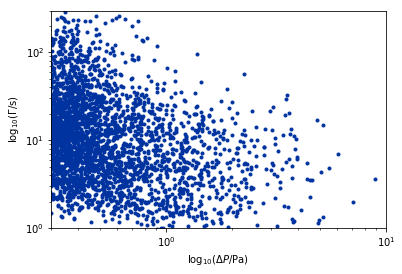

In [31]:
fit_params = np.genfromtxt("alldrop_ordered_durations.txt", delimiter=',', comments="#")
# sol, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, datafile

min_DeltaP = 0.3
min_Gamma = 0.5

ind = (np.abs(fit_params[:,3] - min_DeltaP)/fit_params[:,4] > 3) |\
    (np.abs(fit_params[:,5] - min_Gamma)/fit_params[:,6] > 3)

# plt.errorbar(fit_params[:,3][ind], fit_params[:,5][ind], xerr=fit_params[:,4][ind], yerr=fit_params[:,6][ind], 
#              marker='.', color=BoiseState_blue, ls='')
# plt.axvline(0.3)
# plt.axhline(0.5)

plt.loglog(fit_params[:,3][ind], fit_params[:,5][ind], marker='.', color=BoiseState_blue, ls='')
plt.xlabel(r'$\log_{10}\left(\Delta P\right/{\rm Pa})$')
plt.ylabel(r'$\log_{10}\left(\Gamma\right/{\rm s})$')
plt.xlim([0.3, 10])
plt.ylim([1, 300])
# plt.xscale("log")
# plt.yscale("log")

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """


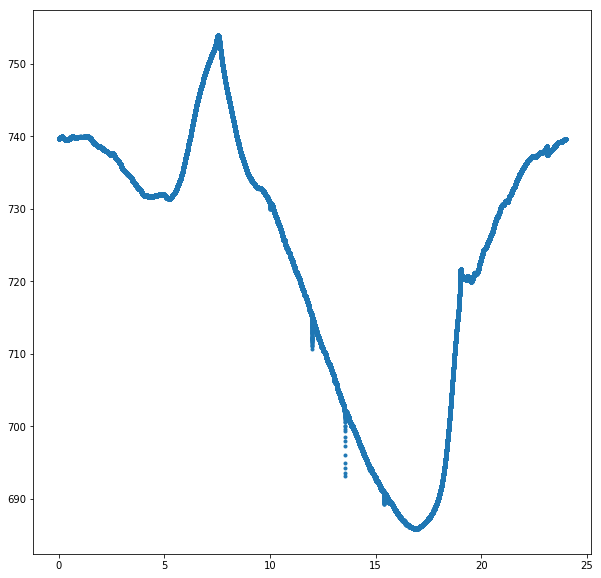

In [4]:
sol = 65
sol_filename = create_datafilename(sol)

# AOBT SCLK LMST LTST UTC PRESSURE PRESSURE_FREQUENCY PRESSURE_TEMP PRESSURE_TEMP_FREQUENCY
sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)
LTST, LTST_and_sol = convert_ltst(sol_data)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.scatter(LTST, sol_data['PRESSURE'], marker='.')

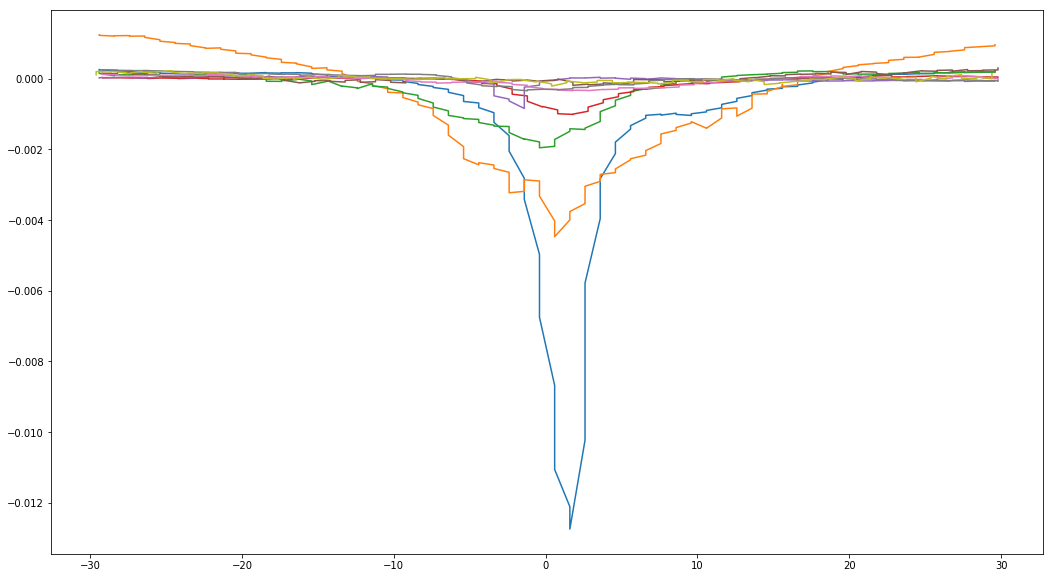

In [10]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ind = Spigas_data['SOL'] == sol
for time in Spigas_data['_LTST_'][ind]:
    x = LTST - time
    time_ind = np.abs(x) < 30/3600.
    md = np.nanmedian(sol_data['PRESSURE'][time_ind])
    ax.plot(x[time_ind]*3600., (sol_data['PRESSURE'][time_ind] - md)/md)

In [11]:
vortices = retrieve_vortices(sol, sol_filename, Spigas_data)

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


1.5636999999999261
1.2388133794940832
0.03621179142914424


/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


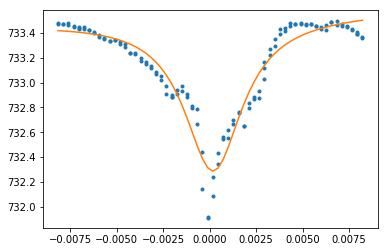

In [9]:
# print(len(Spigas_data['SOL'][Spigas_data['SOL'] == sol]))
which_vortex = 1
# print(Spigas_data[Spigas_data['SOL'] == sol][1])
print(vortices[which_vortex][1][0] - np.min(vortices[which_vortex][1][:]))

plt.plot(vortices[which_vortex][0][:], vortices[which_vortex][1][:], marker='.', ls='')

# modified_lorentzian(t, baseline, slope, t0, DeltaP, Gamma)
init_baseline = 0.5*(vortices[which_vortex][1][0] + vortices[which_vortex][1][-1])
init_slope = (vortices[which_vortex][1][-1] - vortices[which_vortex][1][0])/\
    (vortices[which_vortex][0][-1] - vortices[which_vortex][0][0])
init_t0 = 0.
init_DeltaP = init_baseline - np.min(vortices[which_vortex][1][:])
init_Gamma = 1./3600.

# print(init_baseline, init_slope, init_t0, init_DeltaP, init_Gamma)
popt, pcov = curve_fit(modified_lorentzian, vortices[which_vortex][0][:], vortices[which_vortex][1][:], 
                      p0=[init_baseline, init_slope, init_t0, init_DeltaP, init_Gamma])
print(popt[3])
print(np.diag(np.sqrt(pcov))[3])

plt.plot(vortices[which_vortex][0][:], modified_lorentzian(vortices[which_vortex][0][:], *popt))

In [24]:
# 2020 Jun 18 - Looking at the derivative to see if the vortices show up there.
filename = "alldrop_ordered.txt"
Spigas_data = np.genfromtxt(filename, names=True, delimiter=";", dtype=None)

sol = 15
sol_filename = create_datafilename(sol)

# AOBT SCLK LMST LTST UTC PRESSURE PRESSURE_FREQUENCY PRESSURE_TEMP PRESSURE_TEMP_FREQUENCY
sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)
LTST, LTST_and_sol = convert_ltst(sol_data)

vortices = retrieve_vortices(sol, sol_filename, Spigas_data)

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


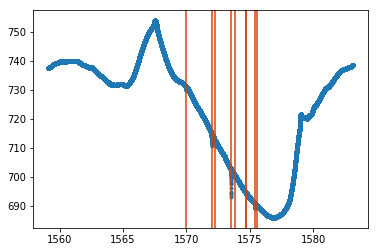

In [12]:
plt.scatter(LTST_and_sol, sol_data['PRESSURE'], marker='.')

ind = Spigas_data['SOL'] == sol
for time in Spigas_data['_LTST_'][ind]:
    plt.axvline(time + sol*24., color=BoiseState_orange)
    
# plt.xlim([370, 375])

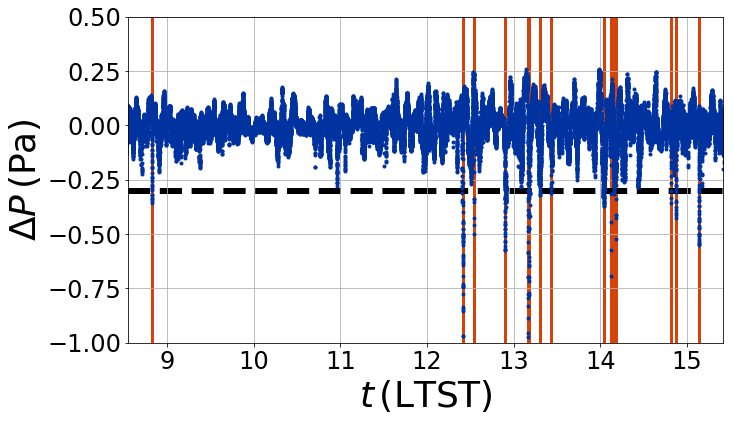

In [25]:
# 2020 Jul 15 - Here's what Spiga et al. did. I do seem to be able to recover their detections 
#   at least for sol 65.

# Filter data as Spiga et al. did
from scipy.signal import savgol_filter

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# High-pass filter the pressure data
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
window_length = int((1000./3600)/delta_t)
pressure_filter = savgol_filter(sol_data['PRESSURE'], window_length, 0, mode='nearest')

ax.plot(LTST, sol_data['PRESSURE'] - pressure_filter, 
        marker='.', ls='', color=BoiseState_blue)

ind = Spigas_data['SOL'] == sol
for time in Spigas_data['_LTST_'][ind]:
    ax.axvline(time, zorder=-1, color=BoiseState_orange, lw=3)
    
ax.set_xlim([np.min(Spigas_data['_LTST_'][ind]) - 1000./3600, 
             np.max(Spigas_data['_LTST_'][ind]) + 1000./3600])

ax.axhline(-0.3, lw=6, ls='--', zorder=-1, color='black')

# ax.set_ylim([0.996 - 1., 1.0005 - 1.])
ax.set_ylim([-1, 0.5])
ax.tick_params(which='both', labelsize=24)
ax.set_xlabel(r'$t\,\left( {\rm LTST} \right)$', fontsize=36)
ax.set_ylabel(r'$\Delta P\,\left({\rm Pa}\right)$', fontsize=36)
ax.grid(True)

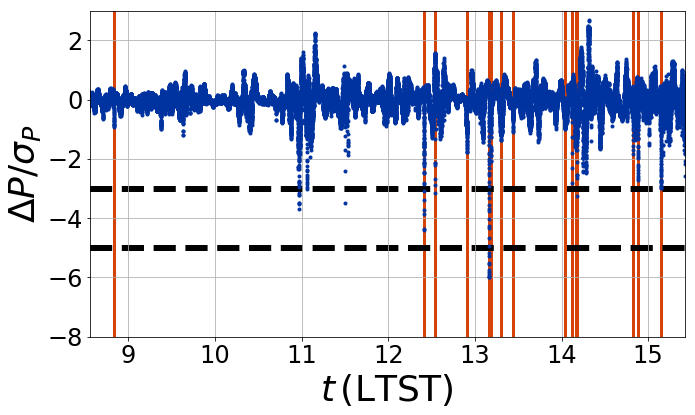

In [26]:
# 2020 Jul 15 - Now filter using moving std
# Filter data as Spiga et al. did

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# High-pass filter the pressure data
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
window_length = int((1000./3600)/delta_t)
pressure_filter = moving_average(sol_data['PRESSURE'], window_length, mode='same')
pressure_std = moving_std(sol_data['PRESSURE'], window_length, mode='same')

y = (sol_data['PRESSURE'] - pressure_filter)/pressure_std
ax.plot(LTST, y,
        marker='.', ls='', color=BoiseState_blue)

ind = Spigas_data['SOL'] == sol
for time in Spigas_data['_LTST_'][ind]:
    ax.axvline(time, zorder=-1, color=BoiseState_orange, lw=3)
    
ax.set_xlim([np.min(Spigas_data['_LTST_'][ind]) - 1000./3600, 
             np.max(Spigas_data['_LTST_'][ind]) + 1000./3600])

# ax.set_xlim([np.min(Spigas_data['_LTST_'][ind]) - 1000./3600, 10])
# ax.set_xlim([12.2, 12.4])
# ax.set_xlim([11.9, 12.1])

# ax.axhline(-0.3, lw=6, ls='--', zorder=-1, color='black')
ax.axhline(-3, lw=6, ls='--', zorder=-1, color='black')
ax.axhline(-5, lw=6, ls='--', zorder=-1, color='black')

# ax.set_ylim([0.996 - 1., 1.0005 - 1.])
ax.set_ylim([-8, 3])
ax.tick_params(which='both', labelsize=24)
ax.set_xlabel(r'$t\,\left( {\rm LTST} \right)$', fontsize=36)
ax.set_ylabel(r'$\Delta P/\sigma_{P}$', fontsize=36)
ax.grid(True)

NameError: name 'LTST_and_sol' is not defined

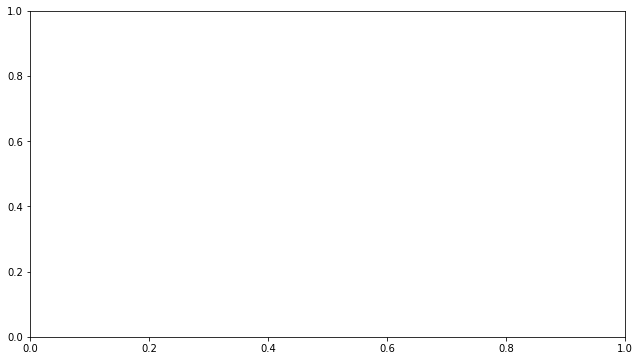

In [3]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# High-pass filter the pressure data
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
window_length = int((1000./3600)/delta_t)
pressure_filter = savgol_filter(sol_data['PRESSURE'], window_length, 0, mode='nearest')

filtered_pressure = sol_data['PRESSURE']/pressure_filter
deriv_filtered_pressure = np.gradient(filtered_pressure, delta_t)

ax.plot(LTST, deriv_filtered_pressure, 
        marker='.', ls='', color=BoiseState_blue)

# collect derivatives just before time
ind = Spigas_data['SOL'] == sol
window = 10./3600 #10-s window before vortex
derivs = np.zeros_like(Spigas_data['_LTST_'][ind])
for i in range(len(Spigas_data['_LTST_'][ind])):
    time = Spigas_data['_LTST_'][ind][i]
    time_ind = (time - LTST) > window
    derivs[i] = np.min(deriv_filtered_pressure[time_ind])
    ax.axvline(time, zorder=-1, color=BoiseState_orange)
    
ax.set_xlim([12.4, 12.6])
ax.tick_params(which='both', labelsize=24)
ax.set_xlabel("$t\,\\left( {\\rm LTST} \\right)$", fontsize=36)
ax.set_ylabel("Filtered Pres. Deriv.", fontsize=28)
ax.grid(True)

In [ ]:
hist, bin_edges = np.histogram(deriv_filtered_pressure, bins="auto")

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ax.semilogy(bin_edges[:-1], hist)
st = np.std(deriv_filtered_pressure)
ax.axvline(-5.*st, color="black", ls='--')
ax.axvline(5.*st, color="black", ls='--')

for i in range(len(derivs)):
    ax.axvline(derivs[i], color=BoiseState_orange)

In [ ]:
# Use a moving average filter with just the pre-time window
window_length = 500
filtered_time = np.zeros_like(sol_data['PRESSURE'][window_length:-1])
filtered_pres = np.zeros_like(sol_data['PRESSURE'][window_length:-1])

for i in range(window_length, len(LTST_and_sol), 1):
    avg = np.nanmedian(sol_data['PRESSURE'][i - window_length:i])
    
    filtered_time[i-window_length-1] = LTST_and_sol[i] - sol*24
    filtered_pres[i-window_length-1] = sol_data['PRESSURE'][i]/avg

In [ ]:
plt.plot(filtered_time, filtered_pres, marker='.', ls='', color=BoiseState_blue)

(-500, 500)

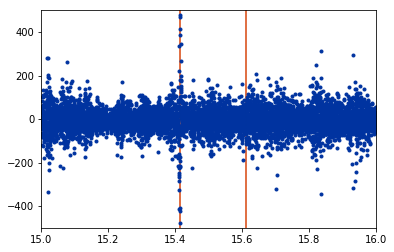

In [13]:
# 2020 Jun 29 - Use only past points to calculate derivative
# And then derivative
window = 10./3600

mx = np.nanmax(np.diff(LTST_and_sol))
deriv_pres = np.diff(sol_data['PRESSURE'])/mx
deriv_time = (LTST_and_sol[1:] - 24.*sol)

plt.plot(deriv_time, deriv_pres, marker='.', ls='', color=BoiseState_blue)

ind = Spigas_data['SOL'] == sol
derivs = np.zeros_like(Spigas_data['_LTST_'][ind])
for i in range(len(Spigas_data['_LTST_'][ind])):
    time = Spigas_data['_LTST_'][ind][i]
    time_ind = (time - deriv_time) > window
    derivs[i] = np.min(deriv_pres[time_ind])
    plt.axvline(time, zorder=-1, color=BoiseState_orange)    
plt.xlim([15, 16])
plt.ylim([-500, 500])

Text(0.5, 1.0, 'Sol 65')

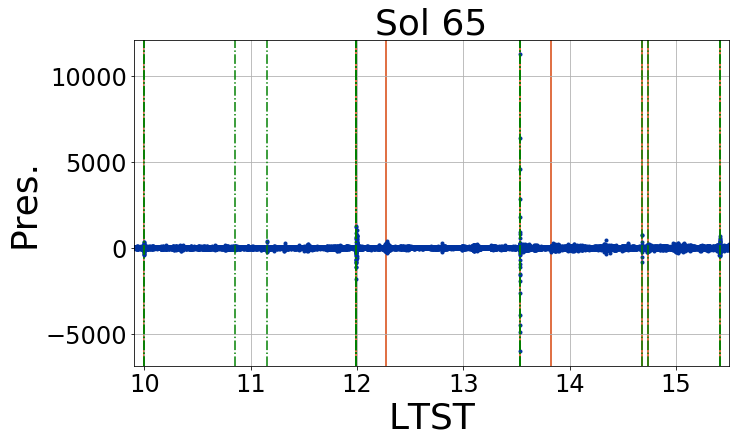

In [15]:
# 2020 Jun 29 - Use only past points to calculate derivative
# And then derivative

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

window = 10./3600

num_points = 2 # Require at least num_points + 1 points in a row with big, negative derivatives
num_sigma = 3.

mx = np.nanmax(np.diff(LTST_and_sol))
deriv_pres = np.diff(sol_data['PRESSURE'])/mx
# st = np.std(deriv_pres)
# Trying mad instead
st = mad(deriv_pres)

deriv_time = (LTST_and_sol[1:] - 24.*sol)

# ax.plot(LTST_and_sol - 24.*sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
plt.plot(deriv_time, deriv_pres, marker='.', ls='', color=BoiseState_blue)

ind = Spigas_data['SOL'] == sol
derivs = np.zeros_like(Spigas_data['_LTST_'][ind])
for i in range(len(Spigas_data['_LTST_'][ind])):
    time = Spigas_data['_LTST_'][ind][i]
    time_ind = (time - deriv_time) > window
    derivs[i] = np.min(deriv_pres[time_ind])
    ax.axvline(time, zorder=-1, color=BoiseState_orange)    

deriv_ind_min = argrelextrema(deriv_pres, np.less)
ind = deriv_pres[deriv_ind_min] < -num_sigma*st    
outlier_ind_min = deriv_ind_min[0][ind]
for cur_ind in outlier_ind_min:
    
    # Calculate the local standard deviation
    
    # Check is the two previous points also had large, negative derivatives
    if(np.all(deriv_pres[cur_ind - num_points:cur_ind] < -num_sigma*st)):
        ax.axvline(deriv_time[cur_ind], color='green', ls='-.')

# pres_ind_min = argrelextrema(sol_data['PRESSURE'], np.less)
# print(LTST_and_sol[pres_ind_min])
# for cur_ind in pres_ind_min[0]:

#     ax.axvline(LTST_and_sol[cur_ind] - 24.*sol, color='green', ls='-.')
    
# plt.xlim([14.8, 14.9])
# plt.ylim([720, 721])

# plt.xlim([12, 13])
# plt.ylim([728, 740])

# plt.xlim([8.75, 9])
# plt.ylim([-200, 200])

# plt.xlim([8.8, 8.85])
# plt.ylim([752, 755])

# ax.set_xlim([9.5, 10.5])
# ax.set_ylim([745, 750])

# ax.set_xlim([9.925, 9.95])
# ax.set_ylim([748, 748.5])

ax.set_xlim([9.9, 15.5])

ax.grid(True)
ax.tick_params(labelsize=24)
ax.set_xlabel("LTST", fontsize=36)
ax.set_ylabel("Pres.", fontsize=36)

ax.set_title("Sol " + str(sol), fontsize=36)

# fig.savefig('recovering-all-vortices_3-2sig-derivs_sol15.png', dpi=500, bbox_inches='tight')

[ -286.19999998  -243.35999998  -228.59999998  -325.79999998
  -261.71999998  -235.79999998  -339.83999998  -362.51999998
  -257.39999998  -230.39999998  -237.59999998  -232.91999998
  -293.03999998  -227.87999998  -358.55999998  -349.55999998
  -235.07999998  -262.43999998  -228.23999998  -245.87999998
  -258.47999998  -246.23999998  -236.87999998  -257.39999998
  -260.63999998  -251.99999998  -236.87999998  -247.31999998
  -238.31999998  -238.31999998  -256.67999998  -267.83999998
  -242.99999998  -297.35999998  -238.31999998  -250.19999998
  -230.75999998  -262.43999998  -357.83999998  -285.11999998
  -270.35999998  -350.27999998  -245.87999998  -320.39999998
  -267.47999998 -1079.99999993  -388.07999997  -635.39999996
  -534.95999996  -307.79999998  -253.43999998  -257.03999998
  -412.55999997  -918.35999994  -294.83999998  -375.11999997
  -667.79999996  -858.95999994  -484.91999997  -293.03999998
  -259.19999998  -227.51999998  -322.55999998  -231.83999998
  -284.39999998  -254.87

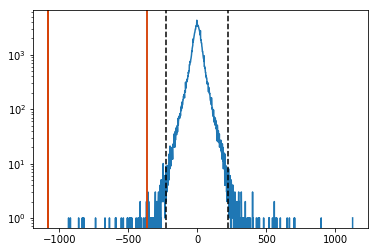

In [31]:
hist, bin_edges = np.histogram(deriv_pres, bins="auto")
plt.semilogy(bin_edges[:-1], hist)
st = np.std(deriv_pres)
plt.axvline(-5.*st, color="black", ls='--')
plt.axvline(5.*st, color="black", ls='--')

for i in range(len(derivs)):
    plt.axvline(derivs[i], color=BoiseState_orange)

In [49]:
# 2020 Jun 29 - Requiring a number of points with large time derivatives

# for local minima
ind_min = argrelextrema(deriv_pres, np.less)
print(deriv_pres[ind_min])

num_points = 3


[ -46.44       -150.11999999 -119.15999999 ... -117.71999999  -80.99999999
  -91.07999999]


In [12]:
# 2020 Jul 13
filename = "alldrop_ordered.txt"
Spigas_data = np.genfromtxt(filename, names=True, delimiter=";", dtype=None)

sol = 65
sol_filename = create_datafilename(sol)

# AOBT SCLK LMST LTST UTC PRESSURE PRESSURE_FREQUENCY PRESSURE_TEMP PRESSURE_TEMP_FREQUENCY
sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)
LTST, LTST_and_sol = convert_ltst(sol_data)

vortices = retrieve_vortices(sol, sol_filename, Spigas_data)

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


[0.08913065 0.08907614 0.08898373 ... 0.09328781 0.09330527 0.09323714]


(-1, 1)

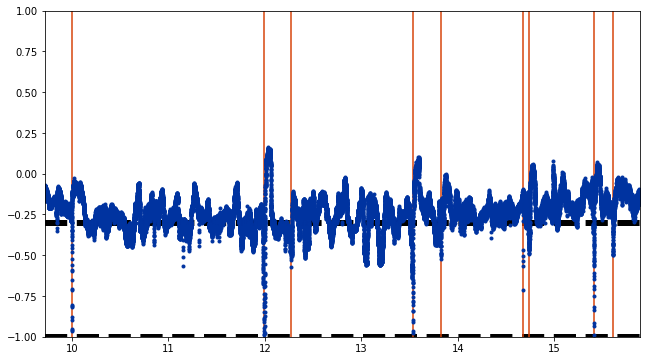

In [30]:
# 2020 Jul 13

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

sampling = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
window = 500./3600
num_window = int(window/sampling)

num_points = 2 # Require at least num_points + 1 points in a row with big departures
num_sigma = 3.

# Drop the points for which we will not calculate a moving average
analysis_time = (LTST_and_sol[num_window:] - 24.*sol)
# ax.plot(LTST_and_sol - 24.*sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
# ax.plot(analysis_time, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)

# Compare current point to last window-size points
past_average = moving_average(sol_data['PRESSURE'], num_window)
st = moving_std(sol_data['PRESSURE'], num_window)
print(st)
scaled_pressure = (sol_data['PRESSURE'][num_window:] - past_average[0:-1])#/st[0:-1]
ax.plot(analysis_time, scaled_pressure, marker='.', ls='', color=BoiseState_blue)
# ax.axhline(-3., lw=6, ls='--', zorder=-1, color='black')
# ax.axhline(-5., lw=6, ls='--', zorder=-1, color='black')

ax.axhline(-0.3, lw=6, ls='--', zorder=-1, color='black')
ax.axhline(-1., lw=6, ls='--', zorder=-1, color='black')


# ax.plot((LTST_and_sol - 24.*sol), sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)

# the_array_I_want[window:] = convolved_x[0:-1]

# for i in range(len(analysis_time) + num_window):
#     avg = np.cumsum(sol_data['PRESSURE'][i - num_window:i])/num_window
#     std = np.std(sol_data['PRESSURE'][i - num_window:i])
    
#     scaled_pres[i] = (sol_data['PRESSURE'][i] - avg)/std
    
# ax.plot(analysis_time, scaled_pres, marker='.', ls='', color=BoiseState_blue)
    
ind = Spigas_data['SOL'] == sol
for i in range(len(Spigas_data['_LTST_'][ind])):
    time = Spigas_data['_LTST_'][ind][i]
    ax.axvline(time, zorder=-1, color=BoiseState_orange)    
    
# ax.grid(True)
# ax.tick_params(labelsize=24)
# ax.set_xlabel("LTST", fontsize=36)
# ax.set_ylabel("Pres.", fontsize=36)

ax.set_xlim([np.min(Spigas_data['_LTST_'][ind]) - 1000./3600, 
             np.max(Spigas_data['_LTST_'][ind]) + 1000./3600])

ax.set_ylim([-1, 1])

# ax.set_title("Sol " + str(sol), fontsize=36)

# # fig.savefig('recovering-all-vortices_3-2sig-derivs_sol15.png', dpi=500, bbox_inches='tight')